In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json
import seaborn as sns
import time

## Data Preparation & Preprocessing

In [2]:
class DataPreparation():
    def __init__(self, dataset_filename, num_steps=None, input_size=None, configs_filename='configs', seed=42):
        self.num_steps = num_steps
        self.input_size = input_size
        self.set_seed(seed)
        self.load_configs(configs_filename)
        self.load_data(dataset_filename)
        
    # Set seed for reproducibility
    def set_seed(self, seed):
        np.random.seed(seed)  # Set seed for numpy
        random.seed(seed)  # Set seed for random
        
        if torch.cuda.is_available():
            torch.manual_seed(seed)  # Set seed for PyTorch CPU
        
        torch.cuda.manual_seed(seed)  # Set seed for PyTorch GPU
        torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
        torch.backends.cudnn.benchmark = False  # Disable the auto-tuner for GPUs
    
    def load_configs(self, configs_filename):
        # Load hyperparameters
        with open(f'configs/{configs_filename}.json', 'r') as file:
            self.hyperparams = json.load(file)
            
    # Load the data
    def load_data(self, dataset_filename):
        self.data = pd.read_csv('data/' + dataset_filename + '.csv')
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data.set_index('Date', inplace=True)
        
        # Round to 2 decimal places
        self.data = self.data.round(2) 
        
        # Extract attributes
        if self.num_steps is None:
            self.num_steps = self.hyperparams['num_steps']  # Extract number of steps
        
        if self.input_size is None:
            self.input_size = self.hyperparams['input_size']  # Extract input size
        
        self.val_split = self.hyperparams['val_split']  # Extract validation split
        self.test_split = self.hyperparams['test_split']  # Extract test split
        self.batch_size = self.hyperparams['batch_size'] # Extract batch size
        self.num_workers = self.hyperparams['num_workers'] # Extract number of workers (for GPU)
        
        # Only care about close price
        self.data = self.data[['Close']]

        # Create sequences (with sliding windows)
        X_train, y_train, X_val, y_val, X_test, y_test = self.create_sequences(self.data, self.input_size, self.num_steps, self.val_split, self.test_split)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        assert(not torch.isnan(X_train_tensor).any())
        assert(not torch.isnan(y_train_tensor).any())
        assert(not torch.isnan(X_val_tensor).any())
        assert(not torch.isnan(y_val_tensor).any())
        assert(not torch.isnan(X_test_tensor).any())
        assert(not torch.isnan(y_test_tensor).any())
        
        # Create DataLoader instances
        self.train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
        self.test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)
            
    # Create sequences
    def create_sequences(self, data, input_size, num_steps, val_split=0.1, test_split=0.1):
        data = [np.array(data[i * input_size: (i + 1) * input_size]) 
           for i in range(len(data) // input_size)]
    
        # Normalize
        data = [data[0] / data[0][0] - 1.0] + [
                    curr / data[i][-1] - 1.0 for i, curr in enumerate(data[1:])]
        
        # Split into groups of `num_steps`
        X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
        y = np.array([data[i + num_steps] for i in range(len(data) - num_steps)])
    
        # Reshape X to have shape (N, num_steps, input_size)
        X = X.reshape(-1, num_steps, input_size)
        y = y.reshape(-1, input_size)  # Reshape y to match the output shape
    
        # Split into train, validation, and test sets
        total_len = len(X)
        test_start = int(total_len * (1 - test_split))
        val_start = int(total_len * (1 - test_split - val_split))
                
        X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
        y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]
        
        return X_train, y_train, X_val, y_val, X_test, y_test
    

## Model Definition: LSTM Cell

In [3]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_i = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_f = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_f = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_c = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_c = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_o = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_o = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        i_t = torch.sigmoid(self.ln_i(torch.mm(x, self.W_i) + torch.mm(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.mm(x, self.W_f) + torch.mm(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.mm(x, self.W_c) + torch.mm(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.mm(x, self.W_o) + torch.mm(h, self.U_o) + self.b_o))

        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())
    
        return h_t, c_t

## Model Definition: GRU Cell

In [4]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_z = nn.LayerNorm(hidden_dim)
        self.ln_r = nn.LayerNorm(hidden_dim)
        self.ln_h = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h):
        z_t = torch.sigmoid(self.ln_z(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z))
        r_t = torch.sigmoid(self.ln_r(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r))
        h_hat_t = torch.tanh(self.ln_h(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_hat_t
        
        assert(not torch.isnan(h_t).any())
    
        return h_t

## Model Definition: RNN

In [5]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if self.cell_type == 'lstm':
                    h_t[layer], c_t[layer] = self.layers[layer](x_t, h_t[layer], c_t[layer])
                else:
                    h_t[layer] = self.layers[layer](x_t, h_t[layer])
                x_t = h_t[layer]

        x = self.dropout(x_t)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## RNN Model Training + Evaluation

In [19]:
# Loss definitions 
def quantile_loss(outputs, targets, quantile=0.5):
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)

class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
        
    def forward(self, outputs, targets):
        return torch.mean(torch.clamp(1 - targets * outputs, min=0))

def directional_loss(outputs, targets):
    return torch.mean(torch.abs(torch.sign(outputs) - torch.sign(targets)))

def choose_loss_function(loss):
    if loss == 'huber':  
        criterion = nn.SmoothL1Loss() 
    elif loss == 'mse': 
        criterion = nn.MSELoss()
    elif loss == 'quantile':
        criterion = quantile_loss(quantile=quantile)
    elif loss == 'hinge':
        criterion = HingeLoss()
    elif loss == 'directional':
        criterion = directional_loss()
    else:
        raise ValueError("Unsupported loss function")

    return criterion

class TrainAndPredict():
    def __init__(self, data_preparation, cell_type, train_needed=None):
        self.train_needed = train_needed
        self.test_loss, self.classification_accuracy, self.duration = self.train_and_predict(data_preparation, cell_type)

    # Extract hyperparameters
    def extract_hyperparams(self, dp, cell_type):
        num_units = dp.hyperparams[cell_type][cell_type + '_units']
        num_layers = dp.hyperparams[cell_type][cell_type + '_layers']
        dropout_rate = dp.hyperparams[cell_type]['dropout_rate']
        dense_units = dp.hyperparams[cell_type]['dense_units']
        init_learning_rate = dp.hyperparams[cell_type]['init_learning_rate']
        learning_rate_decay = dp.hyperparams[cell_type]['learning_rate_decay']
        init_epochs = dp.hyperparams[cell_type]['init_epochs']
        max_epochs = dp.hyperparams[cell_type]['max_epochs']
        early_stop_patience = dp.hyperparams[cell_type].get('early_stop_patience', None)
        
        if self.train_needed is None:
            self.train_needed = dp.hyperparams[cell_type]['pretrain'] # Whether to train the model
        
        return num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, early_stop_patience, self.train_needed  
    
    # Training loop
    def train_model(self, model, train_loader, val_loader, criterion, init_epochs, num_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience=None, cell_type='lstm'):
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        early_stop_counter = 0
    
        learning_rates_to_use = [
        init_learning_rate * (
            learning_rate_decay ** max(float(i + 1 - init_epochs), 0.0)
        ) for i in range(num_epochs)]
        
        for epoch in range(num_epochs):
            model.train()
            current_lr = learning_rates_to_use[epoch]
            optimizer = optim.Adam(model.parameters(), lr=current_lr)
            train_loss = 0.0
            for X_batch, y_batch in tqdm(train_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
    
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
    
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item()
    
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
    
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
            # Early stopping
            if early_stop_patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stop_counter = 0
                    # Save best model
                    torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= early_stop_patience:
                        print("Early stopping triggered")
                        break
        
        return train_losses, val_losses
    
    # Function to load the model
    def load_model(self, model, cell_type, device):
        model_path = f'models/SP500_{cell_type}_model.pth'
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        return model

    # Function to make predictions
    def make_predictions(self, model, data_loader, device):
        model.eval()
        predictions = []
        actuals = []
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(y_batch.cpu().numpy())
                criterion = choose_loss_function('huber')
                test_loss += criterion(outputs, y_batch)
        return np.array(predictions).flatten(), np.array(actuals).flatten(), test_loss.item()
    
    # Plot the predictions against the actual values
    def plot_results(self, data_preparation, actuals, predictions):
        plt.figure(figsize=(10, 5))
        x = np.arange(len(actuals))
        plt.bar(x - 0.2, actuals, label='Actual Prices')
        plt.bar(x + 0.2, predictions, label='Predicted Prices')
        plt.xlabel('Value')
        plt.ylabel('Normalized Price')
        plt.ylim(-0.1, 0.1)
        plt.title(f'Predicted vs Actual Prices for input_size={data_preparation.input_size}, num_steps={data_preparation.num_steps}')
        plt.legend()
        plt.show()
    
    # Check for overfitting/underfitting
    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def train_and_predict(self, data_preparation, cell_type):
        # Initialize model
        num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, early_stop_patience, train_needed = self.extract_hyperparams(data_preparation, cell_type)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = CustomRNNModel(input_dim=data_preparation.input_size, hidden_dim=num_units, output_dim=data_preparation.input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=cell_type).to(device)
        
        # Train or load the model
        if train_needed:
            # Train the model
            criterion = choose_loss_function('huber')
            t1 = time.time()
            train_losses, val_losses = self.train_model(model, data_preparation.train_loader, data_preparation.val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience, cell_type=cell_type)
            duration = time.time() - t1
            
            torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
        else:
            # Load the model
            model = self.load_model(model, cell_type, device)
            print("Model loaded successfully")
        
        # Get a model summary
        print(model)
        
        # Get predictions and actual values
        predictions, actuals, test_loss = self.make_predictions(model, data_preparation.test_loader, device)
        
        # Plot the predictions against the actual values
        self.plot_results(data_preparation, actuals, predictions)
        
        # Check for overfitting/underfitting
        self.plot_losses(train_losses, val_losses)
        
        # Classification rate
        classification_accuracy = np.mean((predictions > 0) == (actuals > 0))
    
        return test_loss, classification_accuracy, duration

In [20]:
dataset_name = 'SP500'

100%|█████████████████████████████████████████| 107/107 [00:03<00:00, 29.38it/s]


Epoch 1/10, Train Loss: 0.0009, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 37.47it/s]


Epoch 2/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.18it/s]


Epoch 3/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.46it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.50it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.96it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 40.96it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.78it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.49it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 42.56it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


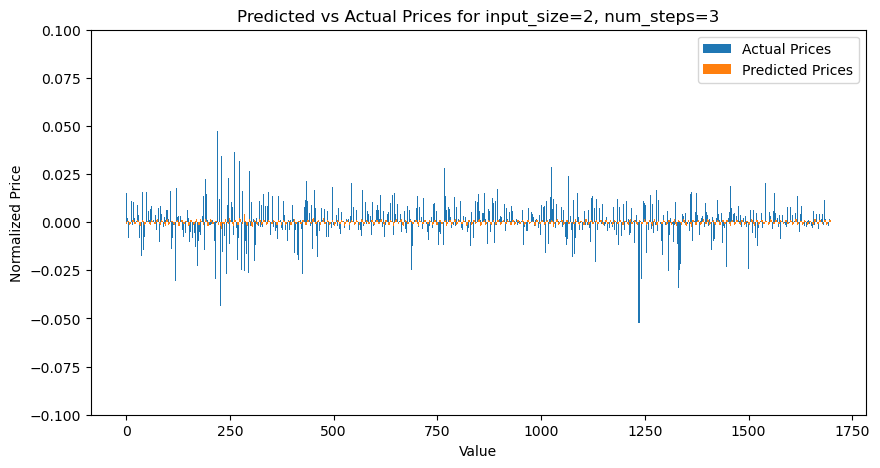

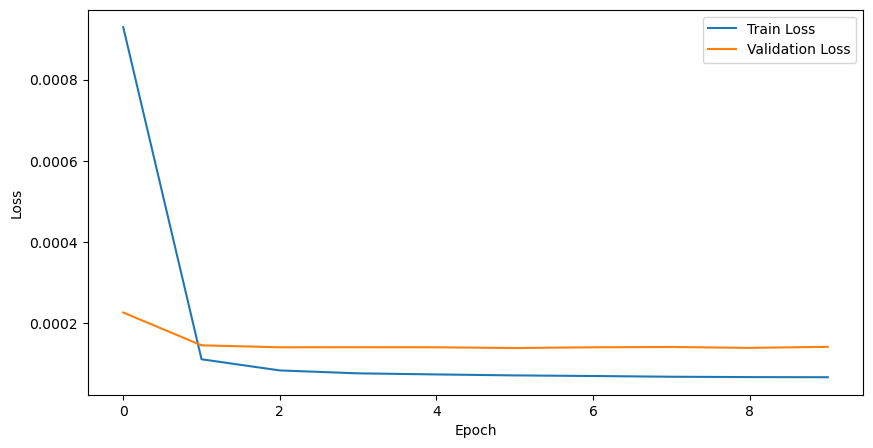

In [21]:
data_preparation = DataPreparation(dataset_name)
cell_type = 'lstm'
evaluation_results = TrainAndPredict(data_preparation, cell_type)

100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 45.51it/s]


Epoch 1/10, Train Loss: 0.0030, Val Loss: 0.0004


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 47.00it/s]


Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 47.38it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 45.92it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 45.99it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 47.11it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 42.72it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 45.94it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 46.44it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 38.95it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


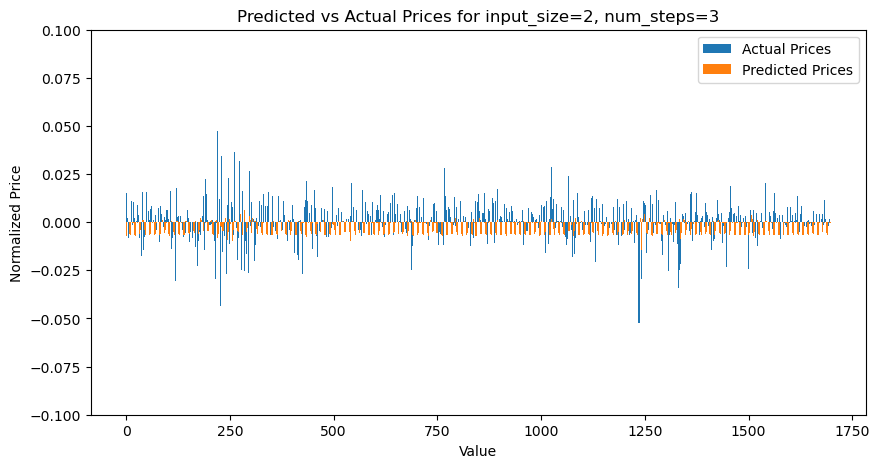

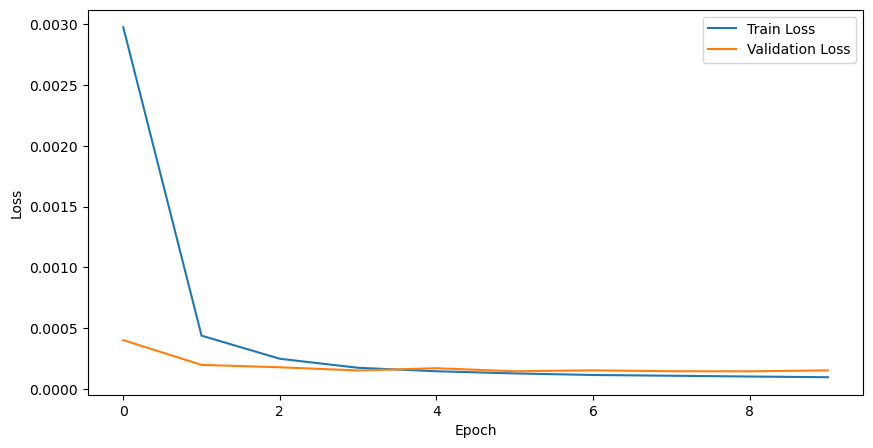

In [22]:
data_preparation = DataPreparation(dataset_name)
cell_type = 'gru'
evaluation_results = TrainAndPredict(data_preparation, cell_type)

## Hyperparameter Search over `input_size` and `num_steps`

In [23]:
def grid_search(cell_type, input_size_values, num_steps_values):
    # Define dataframe
    df = pd.DataFrame(columns=['Input Size', 'Number of Steps', 'Test Loss', 'Classification Accuracy', 'Duration'])
    
    # Define test losses & classification accuracies
    input_size_combination_values = []
    num_steps_combination_values = []

    # Define hyperparam combinations
    test_losses = []
    classification_accuracies = []
    durations = []
    
    # Loop over the hyperparam values
    for input_size in input_size_values:
        for num_steps in num_steps_values:
            # Add to hyperparam combination
            input_size_combination_values.append(input_size)
            num_steps_combination_values.append(num_steps)
            
            # Modify the input_size and num_steps attributes
            data_preparation = DataPreparation(dataset_name, num_steps=num_steps, input_size=input_size)
            
            # Train & Evaluate model
            evaluation_results = TrainAndPredict(data_preparation, cell_type, train_needed=True)
            test_losses.append(evaluation_results.test_loss)
            classification_accuracies.append(evaluation_results.classification_accuracy)   
            durations.append(evaluation_results.duration)
    
    df['Input Size'] = input_size_combination_values
    df['Number of Steps'] = num_steps_combination_values
    df['Test Loss'] = test_losses
    df['Classification Accuracy'] = classification_accuracies
    df['Duration'] = durations
    
    df.to_csv(f'results/{cell_type}_evaluation_results.csv')

In [24]:
def get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=False):
    # Perform grid search if needed (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
    if SEARCH_NEEDED:
        grid_search(cell_type, input_size_values, num_steps_values)
    
    # Get best model
    df = pd.read_csv(f'results/{cell_type}_evaluation_results.csv')
    idx = np.argmin(df['Test Loss'])
    df_best_model = df.iloc[idx, :]
    return df_best_model

In [25]:
input_size_values = [2, 3, 5, 10, 20]
num_steps_values = [3, 10, 20, 30, 40, 50]

100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 37.80it/s]


Epoch 1/10, Train Loss: 0.0006, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.59it/s]


Epoch 2/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.37it/s]


Epoch 3/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 42.06it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.46it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 38.79it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.32it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.11it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 40.91it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 36.28it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


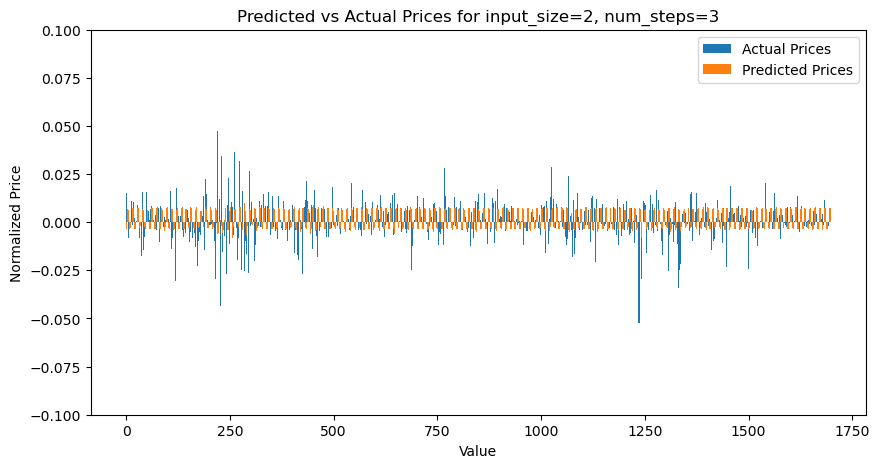

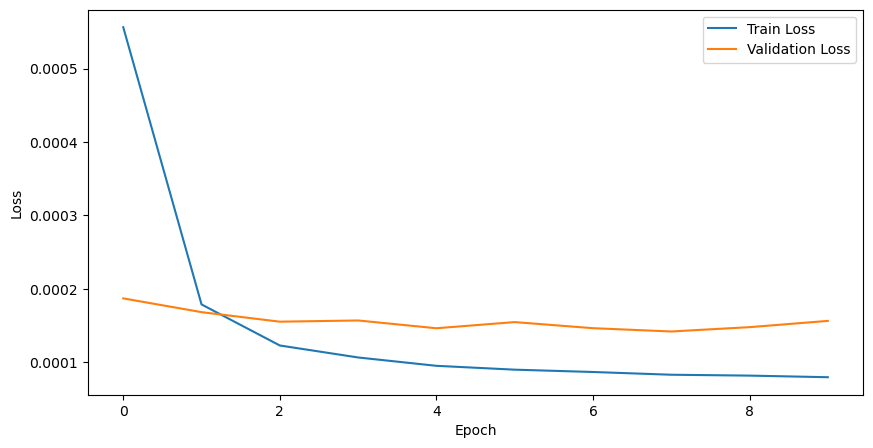

100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 19.75it/s]


Epoch 1/10, Train Loss: 0.0011, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 20.21it/s]


Epoch 2/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 19.84it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 19.08it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 20.13it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 20.30it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 20.18it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 19.99it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 20.20it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:05<00:00, 20.26it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


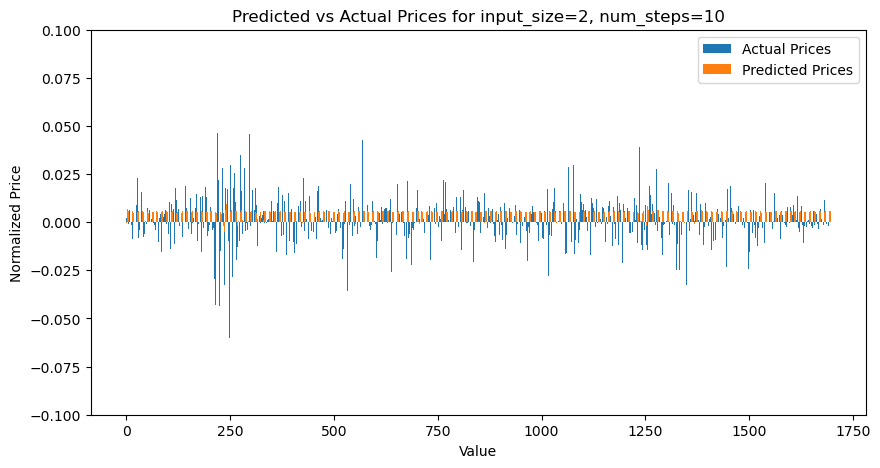

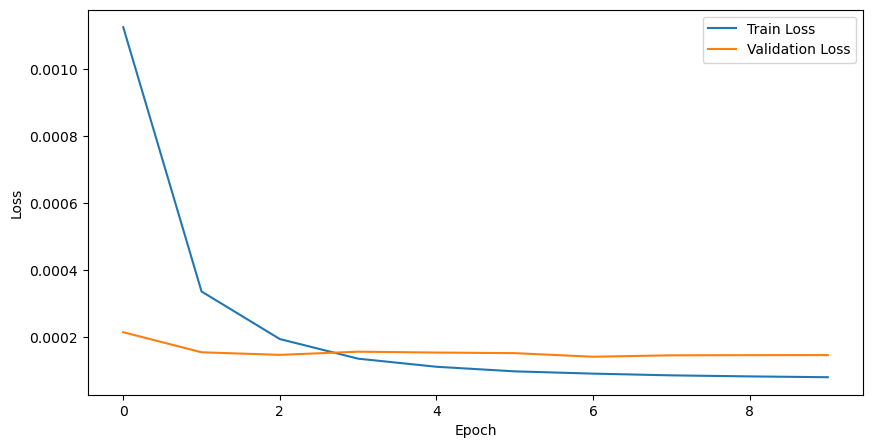

100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.20it/s]


Epoch 1/10, Train Loss: 0.0042, Val Loss: 0.0006


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.32it/s]


Epoch 2/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.70it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.58it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.66it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.66it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.45it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:08<00:00, 11.80it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.75it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 11.76it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


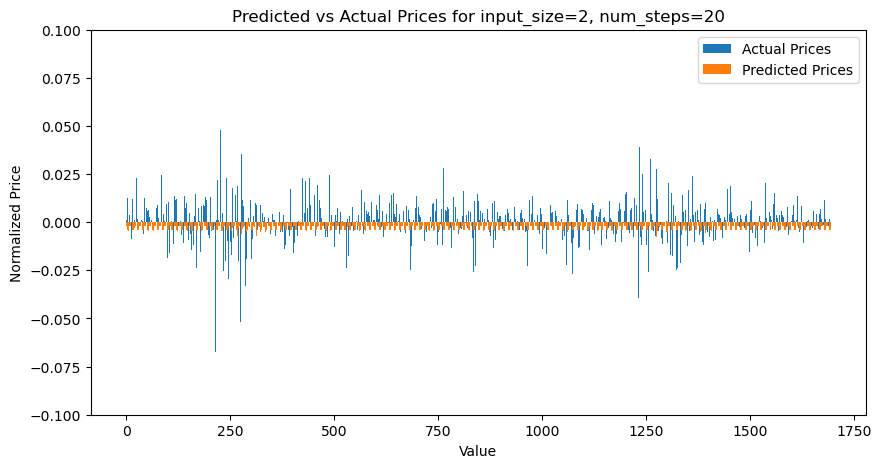

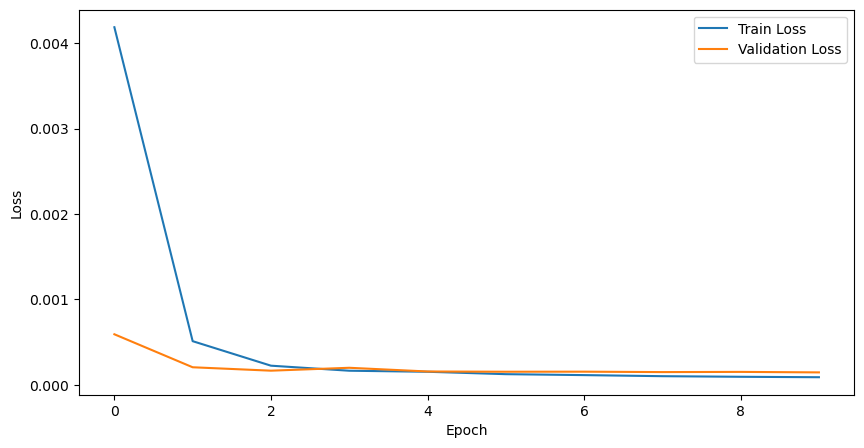

100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.05it/s]


Epoch 1/10, Train Loss: 0.0054, Val Loss: 0.0008


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.07it/s]


Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.24it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.26it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.26it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.17it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.13it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.10it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  7.97it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.06it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


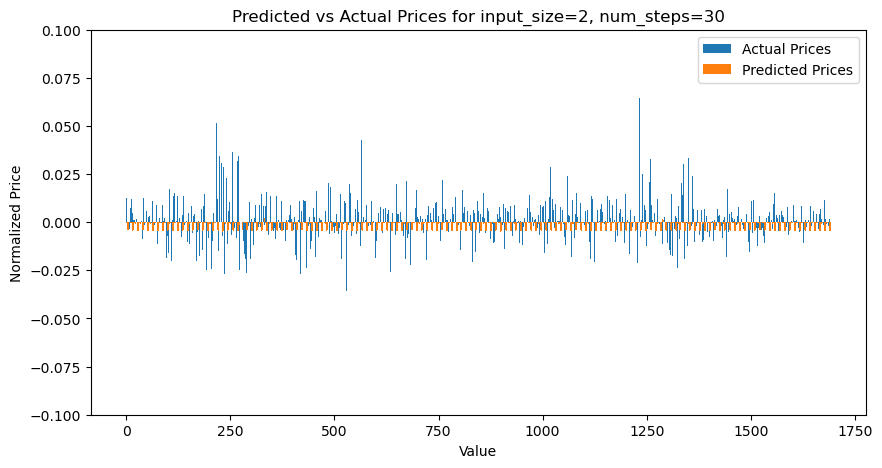

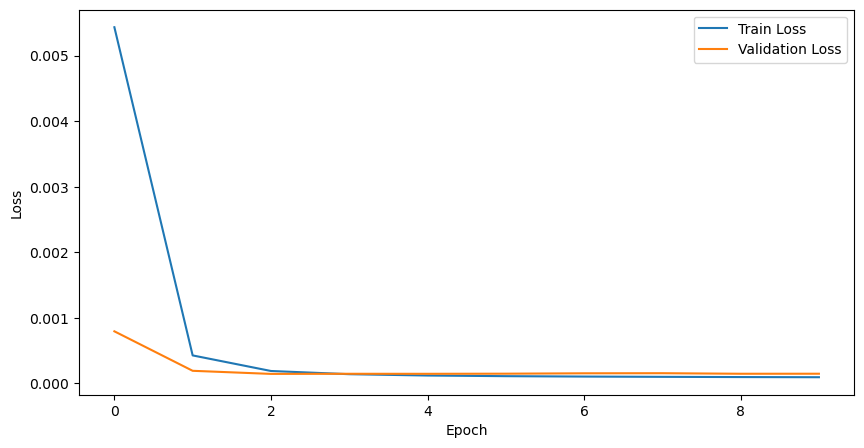

100%|█████████████████████████████████████████| 106/106 [00:17<00:00,  6.14it/s]


Epoch 1/10, Train Loss: 0.0035, Val Loss: 0.0010


100%|█████████████████████████████████████████| 106/106 [00:17<00:00,  6.16it/s]


Epoch 2/10, Train Loss: 0.0012, Val Loss: 0.0004


100%|█████████████████████████████████████████| 106/106 [00:17<00:00,  6.14it/s]


Epoch 3/10, Train Loss: 0.0006, Val Loss: 0.0003


100%|█████████████████████████████████████████| 106/106 [00:16<00:00,  6.24it/s]


Epoch 4/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:16<00:00,  6.30it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:17<00:00,  6.20it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:17<00:00,  6.23it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:16<00:00,  6.36it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:16<00:00,  6.32it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:16<00:00,  6.37it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


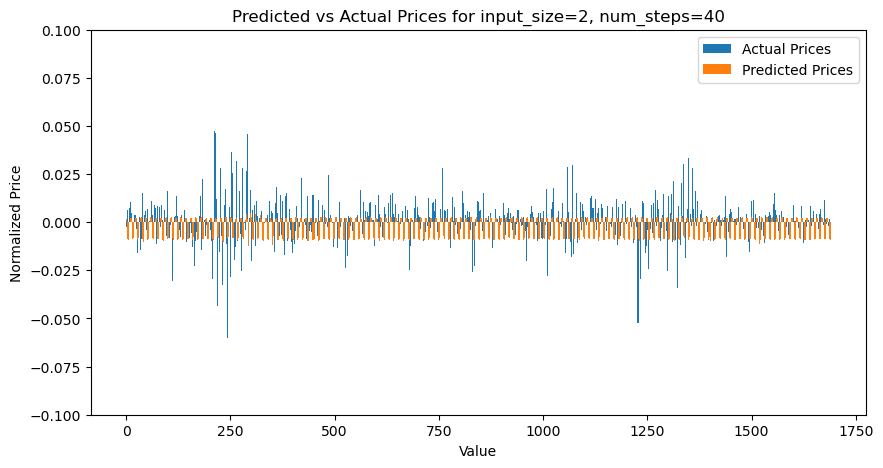

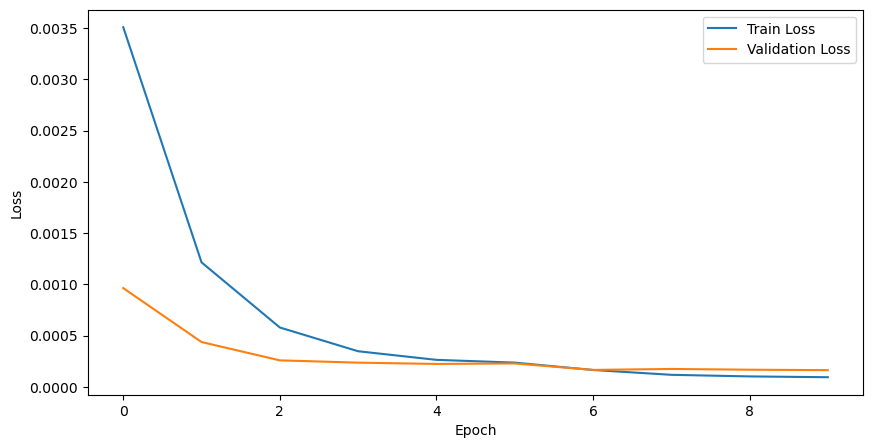

100%|█████████████████████████████████████████| 106/106 [00:21<00:00,  5.03it/s]


Epoch 1/10, Train Loss: 0.0051, Val Loss: 0.0018


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.07it/s]


Epoch 2/10, Train Loss: 0.0008, Val Loss: 0.0004


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.16it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.11it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.14it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.10it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.19it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.16it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.11it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:20<00:00,  5.14it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


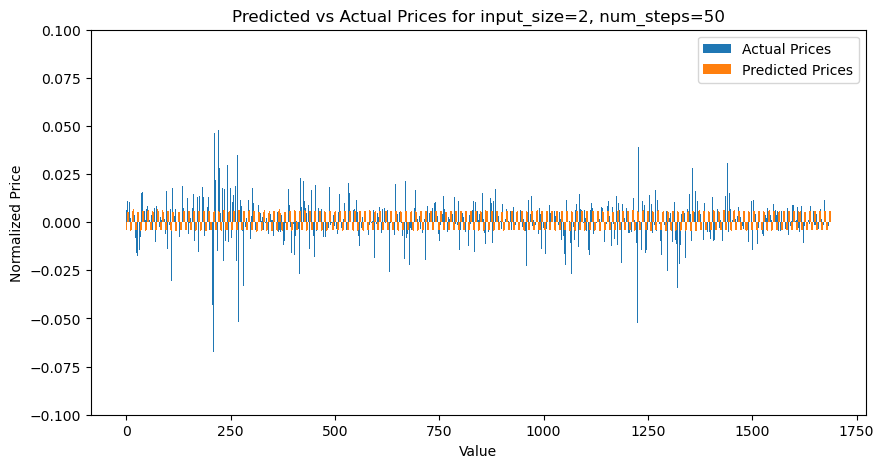

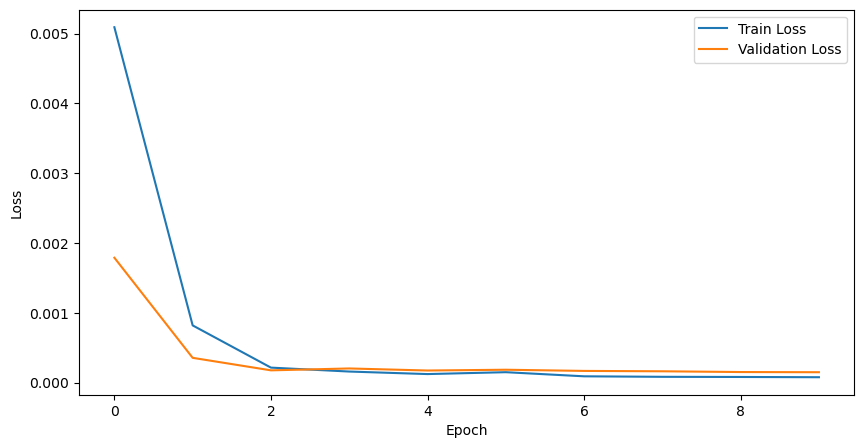

100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 31.49it/s]


Epoch 1/10, Train Loss: 0.0013, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 33.24it/s]


Epoch 2/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.19it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.79it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.20it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 31.34it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.93it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.00it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.77it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 33.48it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


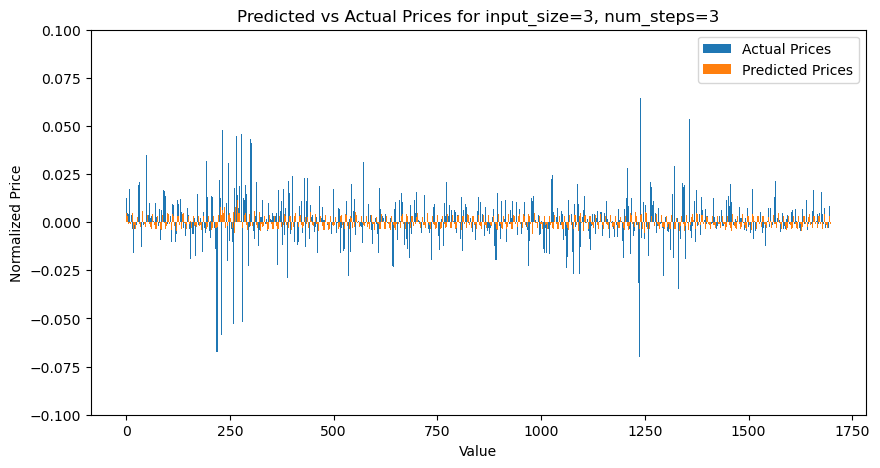

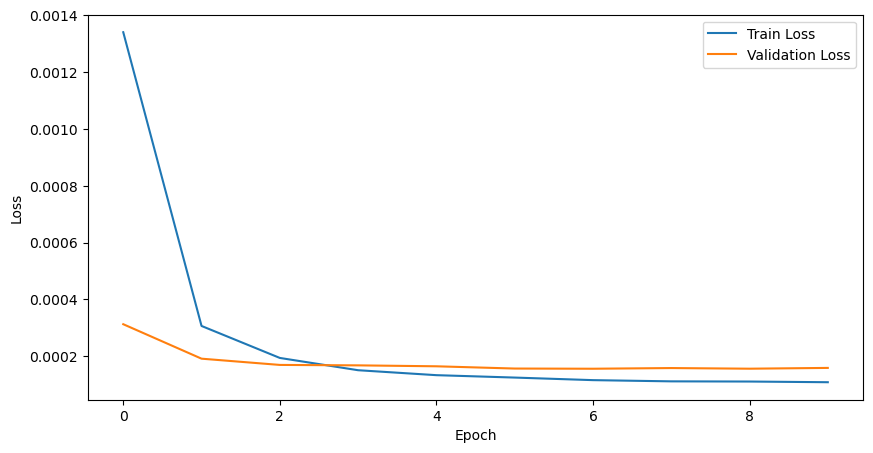

100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.40it/s]


Epoch 1/10, Train Loss: 0.0028, Val Loss: 0.0006


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.45it/s]


Epoch 2/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.64it/s]


Epoch 3/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.56it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.65it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.58it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 17.82it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 17.27it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:04<00:00, 16.65it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 17.85it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


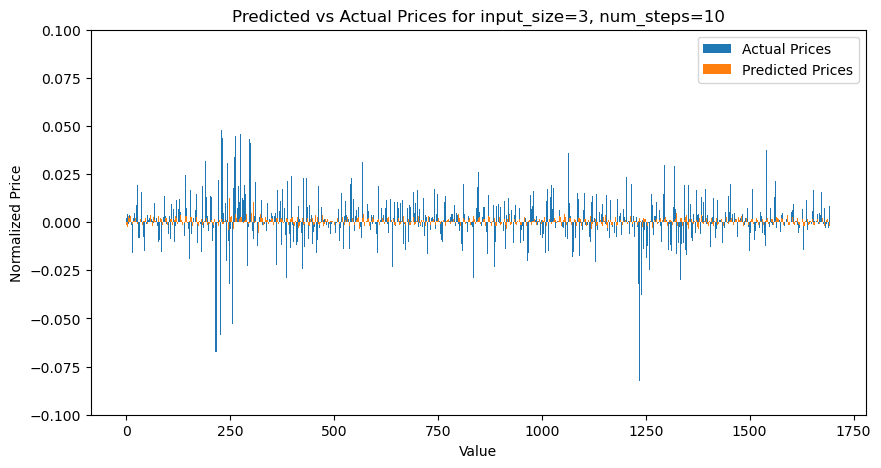

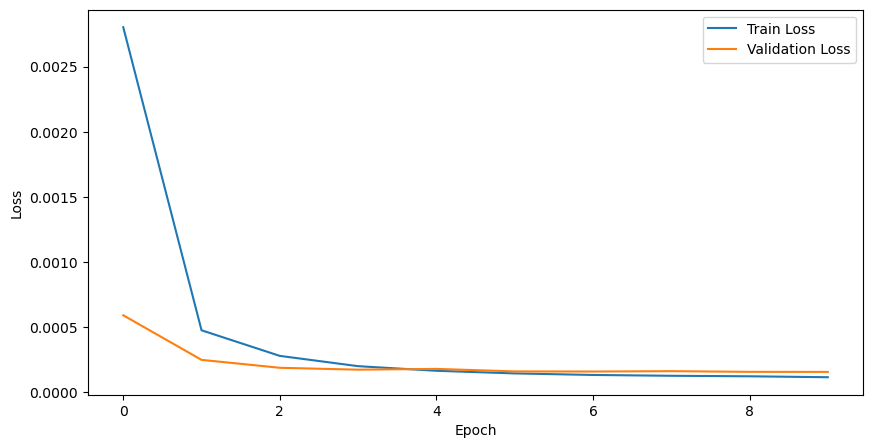

100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.17it/s]


Epoch 1/10, Train Loss: 0.0013, Val Loss: 0.0004


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.47it/s]


Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.70it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.74it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.77it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.59it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.78it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.57it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00, 10.12it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|███████████████████████████████████████████| 71/71 [00:06<00:00, 10.47it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


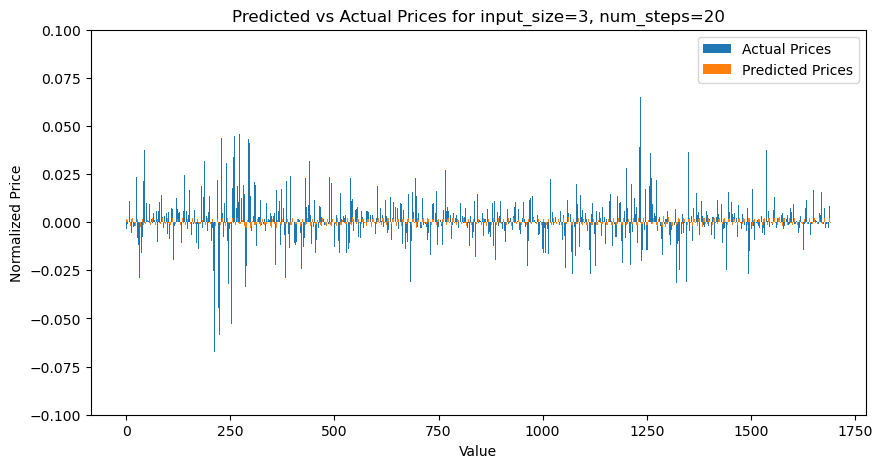

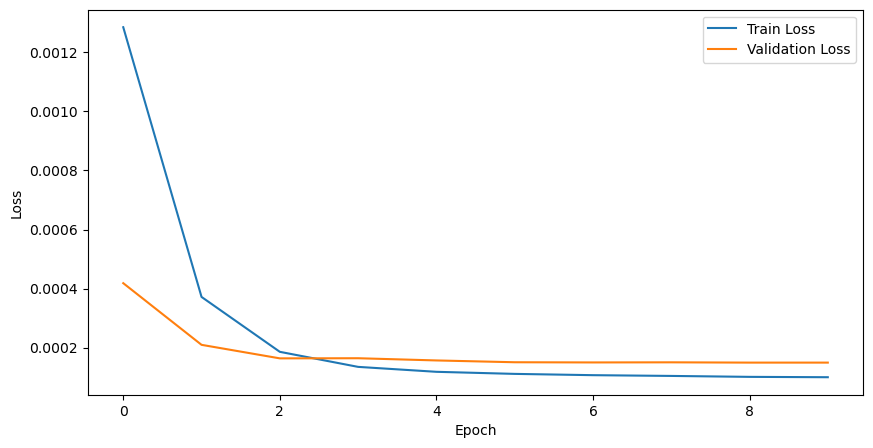

100%|███████████████████████████████████████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 1/10, Train Loss: 0.0044, Val Loss: 0.0017


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.40it/s]


Epoch 2/10, Train Loss: 0.0012, Val Loss: 0.0007


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.62it/s]


Epoch 3/10, Train Loss: 0.0007, Val Loss: 0.0005


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.49it/s]


Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.65it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.69it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.50it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.77it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.75it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.66it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


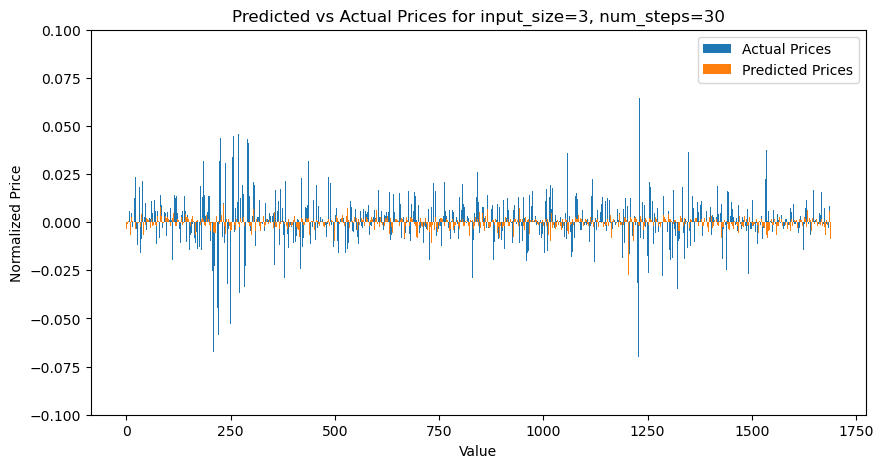

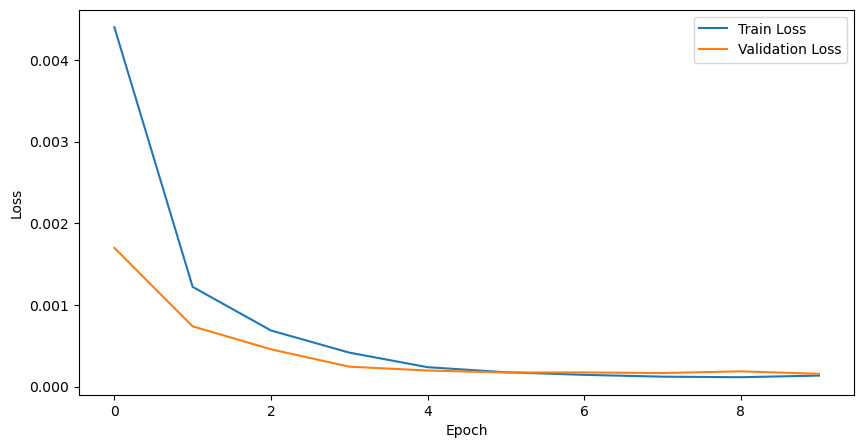

100%|███████████████████████████████████████████| 71/71 [00:12<00:00,  5.84it/s]


Epoch 1/10, Train Loss: 0.0041, Val Loss: 0.0011


100%|███████████████████████████████████████████| 71/71 [00:12<00:00,  5.87it/s]


Epoch 2/10, Train Loss: 0.0012, Val Loss: 0.0005


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.02it/s]


Epoch 3/10, Train Loss: 0.0007, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  5.98it/s]


Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  5.96it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:12<00:00,  5.73it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:12<00:00,  5.91it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:12<00:00,  5.65it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.02it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  5.94it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


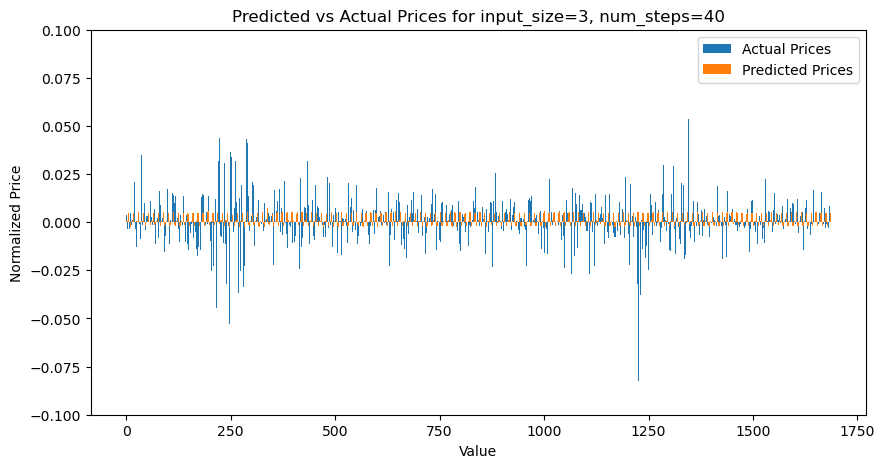

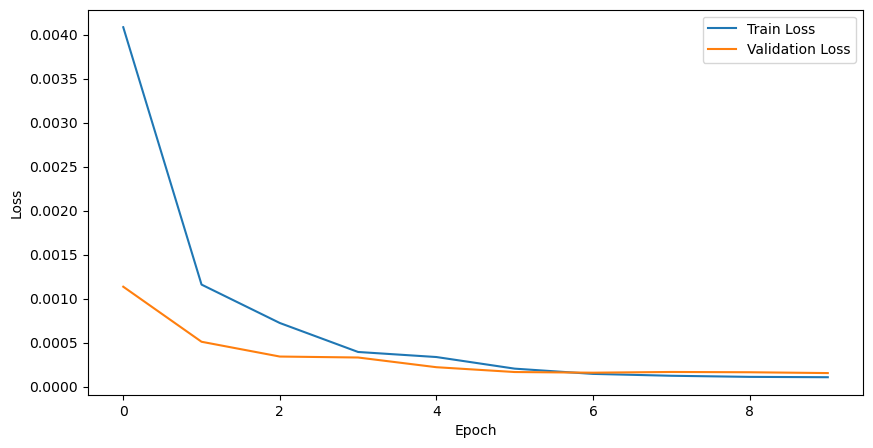

100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.85it/s]


Epoch 1/10, Train Loss: 0.0046, Val Loss: 0.0015


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.86it/s]


Epoch 2/10, Train Loss: 0.0014, Val Loss: 0.0006


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.82it/s]


Epoch 3/10, Train Loss: 0.0006, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.75it/s]


Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.88it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.91it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.93it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.92it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.84it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:14<00:00,  4.94it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


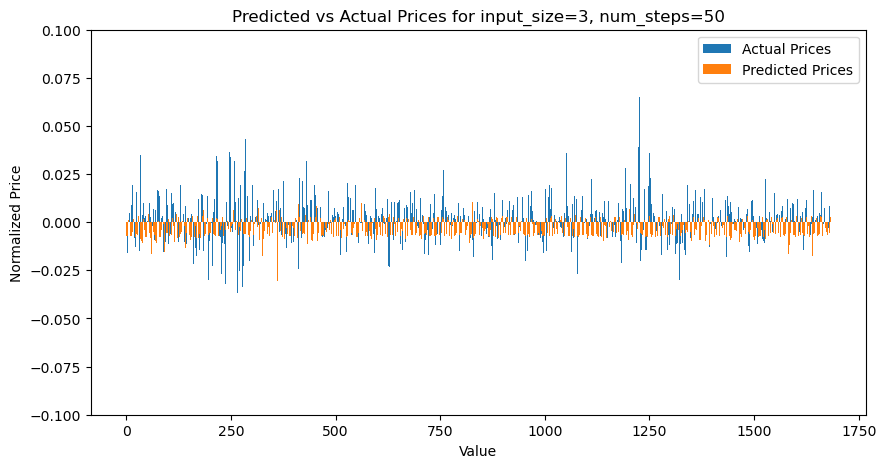

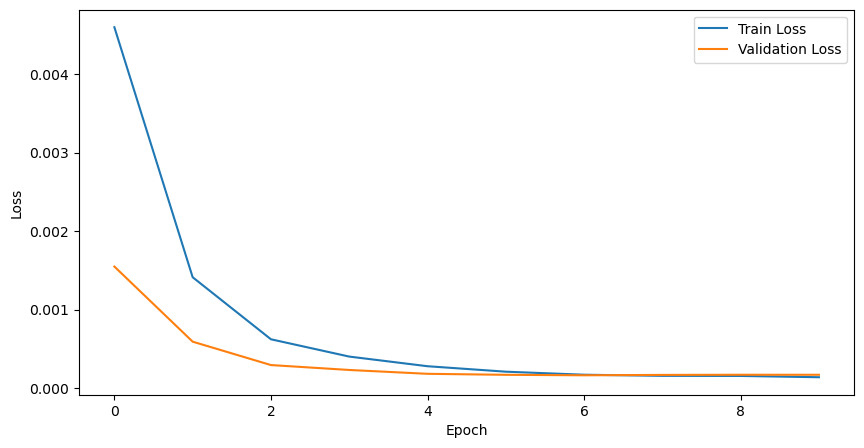

100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 20.45it/s]


Epoch 1/10, Train Loss: 0.0028, Val Loss: 0.0009


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 21.40it/s]


Epoch 2/10, Train Loss: 0.0007, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.41it/s]


Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 22.94it/s]


Epoch 4/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 22.95it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.20it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 22.61it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.36it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 22.68it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 21.84it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


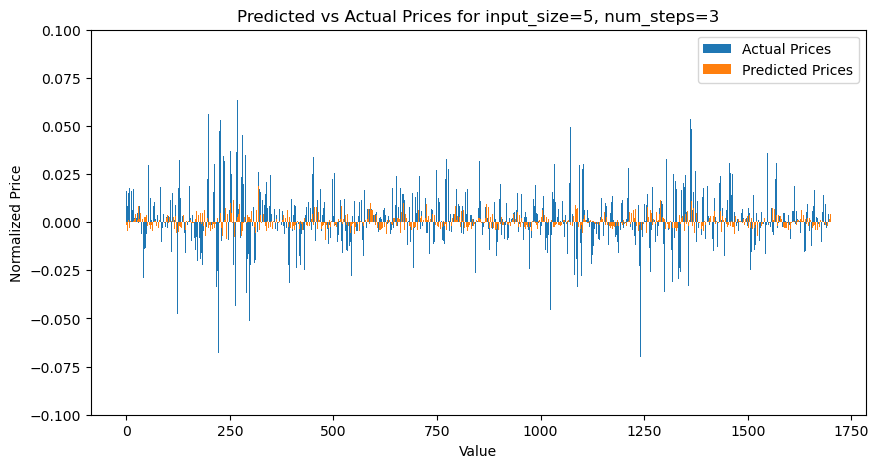

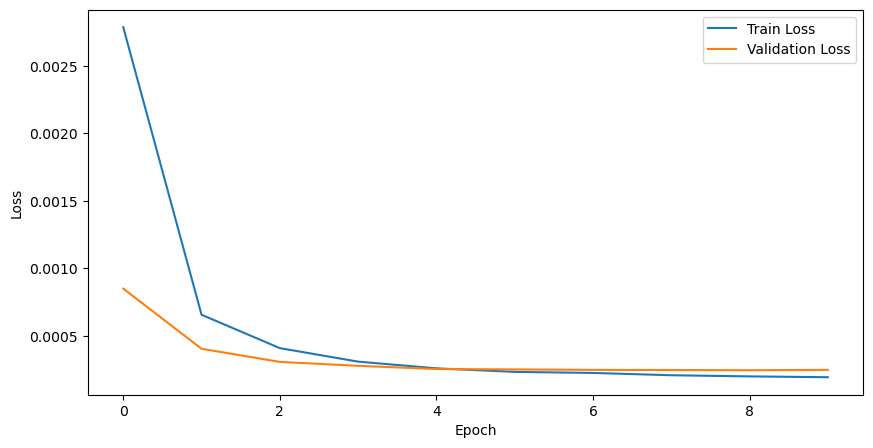

100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 14.16it/s]


Epoch 1/10, Train Loss: 0.0056, Val Loss: 0.0017


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 13.94it/s]


Epoch 2/10, Train Loss: 0.0011, Val Loss: 0.0005


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 14.33it/s]


Epoch 3/10, Train Loss: 0.0007, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 13.00it/s]


Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 14.17it/s]


Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 14.34it/s]


Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 13.51it/s]


Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 13.46it/s]


Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 14.16it/s]


Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 14.42it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


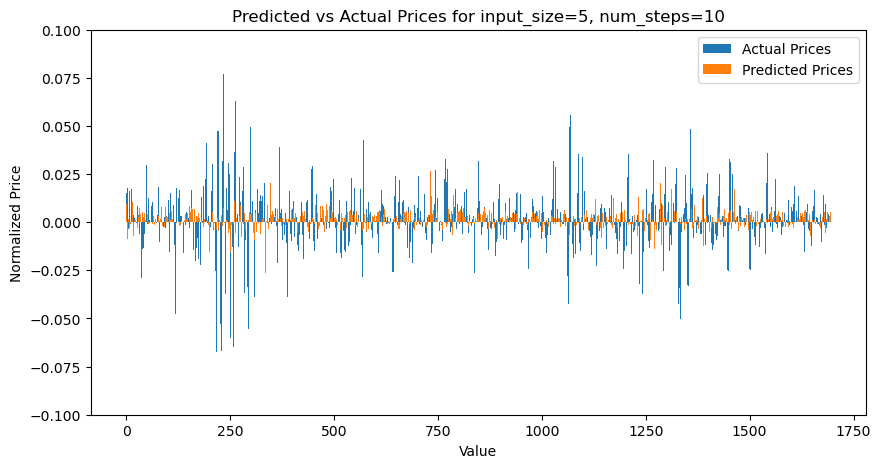

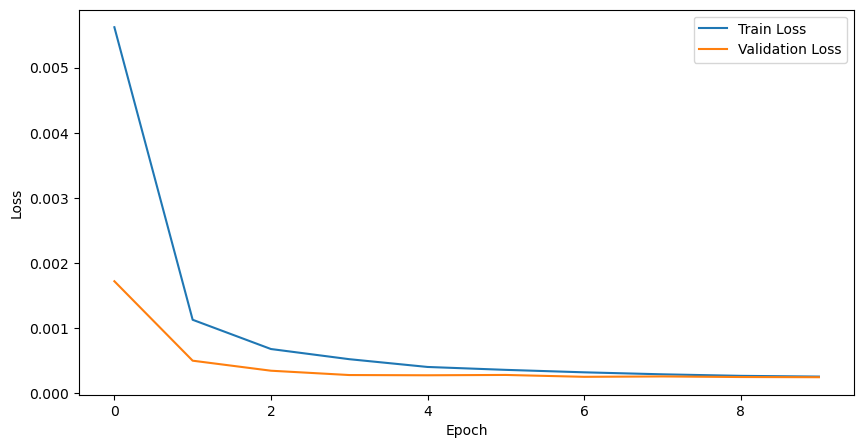

100%|███████████████████████████████████████████| 43/43 [00:05<00:00,  8.52it/s]


Epoch 1/10, Train Loss: 0.0099, Val Loss: 0.0052


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.28it/s]


Epoch 2/10, Train Loss: 0.0026, Val Loss: 0.0007


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.46it/s]


Epoch 3/10, Train Loss: 0.0008, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.44it/s]


Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.32it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.32it/s]


Epoch 6/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.22it/s]


Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.33it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.29it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  9.23it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0003
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


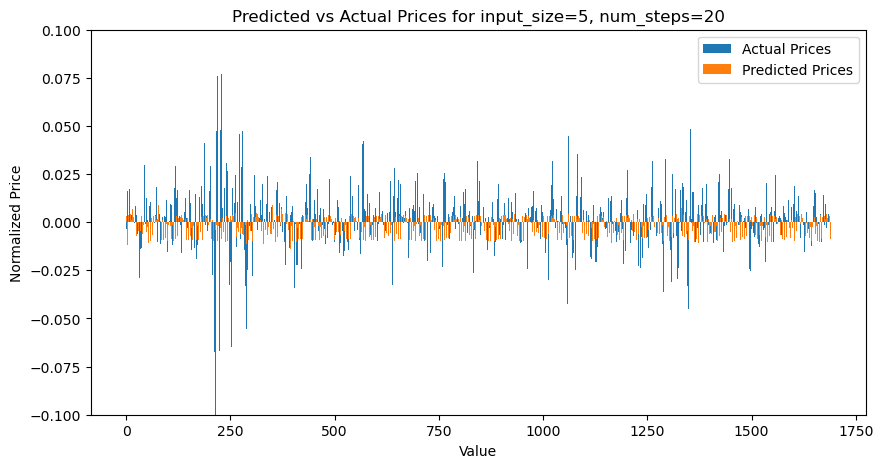

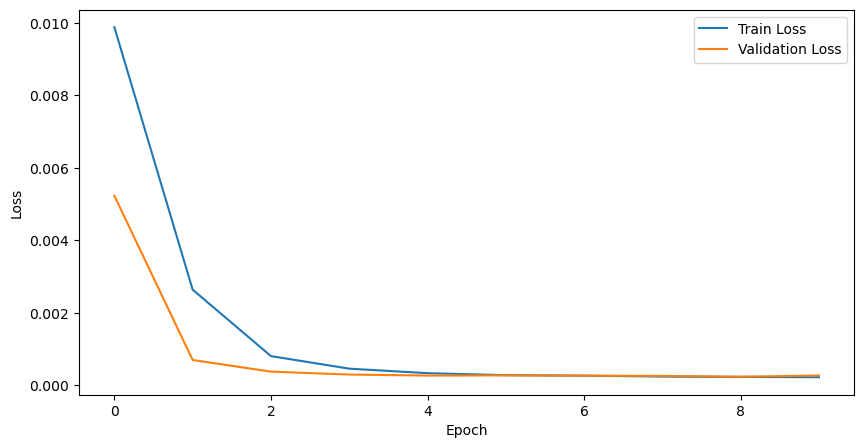

100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.80it/s]


Epoch 1/10, Train Loss: 0.0082, Val Loss: 0.0050


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.84it/s]


Epoch 2/10, Train Loss: 0.0037, Val Loss: 0.0020


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.86it/s]


Epoch 3/10, Train Loss: 0.0014, Val Loss: 0.0006


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.92it/s]


Epoch 4/10, Train Loss: 0.0007, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.94it/s]


Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  7.02it/s]


Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.99it/s]


Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.86it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  6.79it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:06<00:00,  7.03it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


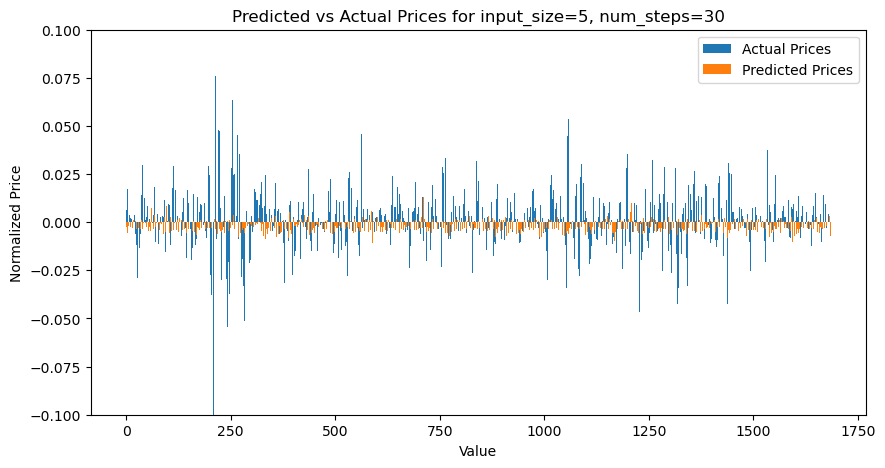

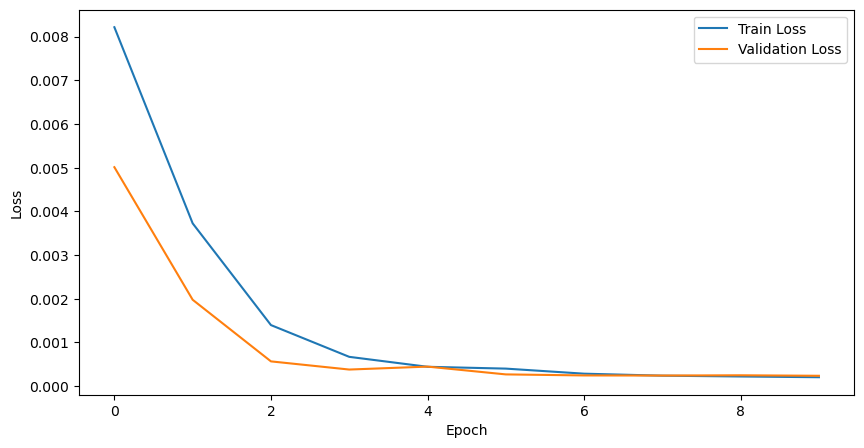

100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.42it/s]


Epoch 1/10, Train Loss: 0.0053, Val Loss: 0.0027


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.44it/s]


Epoch 2/10, Train Loss: 0.0020, Val Loss: 0.0012


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.42it/s]


Epoch 3/10, Train Loss: 0.0010, Val Loss: 0.0007


100%|███████████████████████████████████████████| 42/42 [00:08<00:00,  5.25it/s]


Epoch 4/10, Train Loss: 0.0007, Val Loss: 0.0005


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.42it/s]


Epoch 5/10, Train Loss: 0.0005, Val Loss: 0.0004


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.43it/s]


Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.45it/s]


Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.45it/s]


Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.37it/s]


Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.26it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


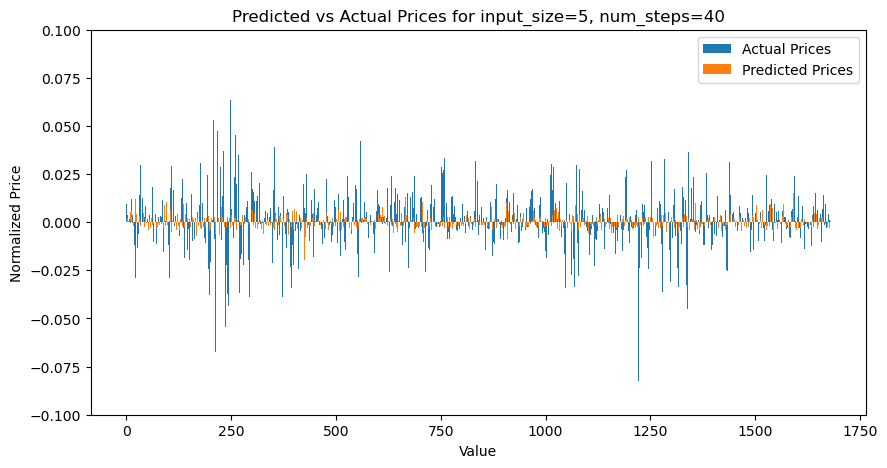

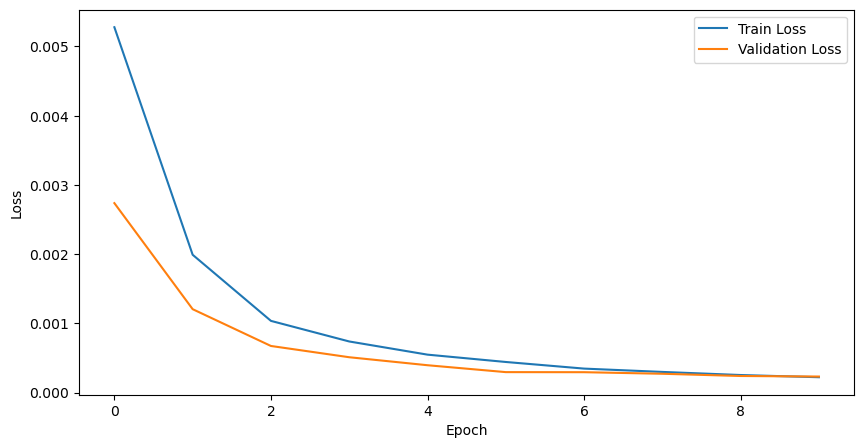

100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.50it/s]


Epoch 1/10, Train Loss: 0.0101, Val Loss: 0.0069


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.48it/s]


Epoch 2/10, Train Loss: 0.0051, Val Loss: 0.0031


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.44it/s]


Epoch 3/10, Train Loss: 0.0026, Val Loss: 0.0017


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.40it/s]


Epoch 4/10, Train Loss: 0.0018, Val Loss: 0.0014


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.38it/s]


Epoch 5/10, Train Loss: 0.0012, Val Loss: 0.0007


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.46it/s]


Epoch 6/10, Train Loss: 0.0007, Val Loss: 0.0004


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.47it/s]


Epoch 7/10, Train Loss: 0.0006, Val Loss: 0.0004


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 8/10, Train Loss: 0.0005, Val Loss: 0.0004


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.50it/s]


Epoch 9/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.53it/s]


Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0003
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


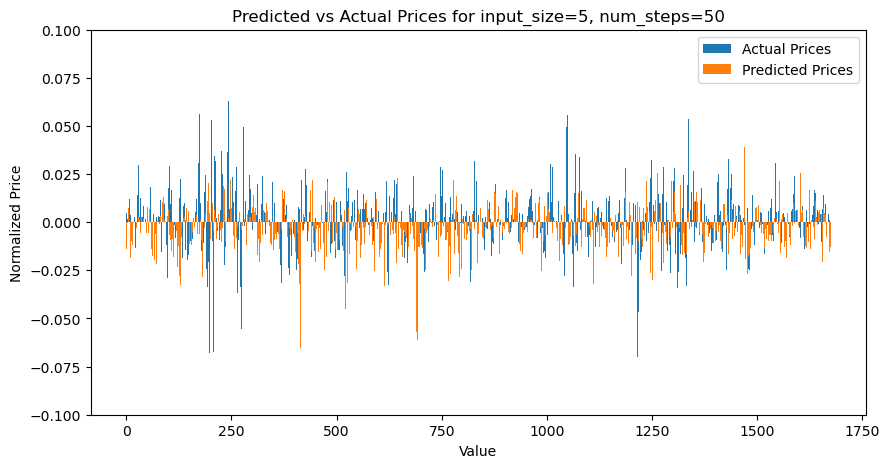

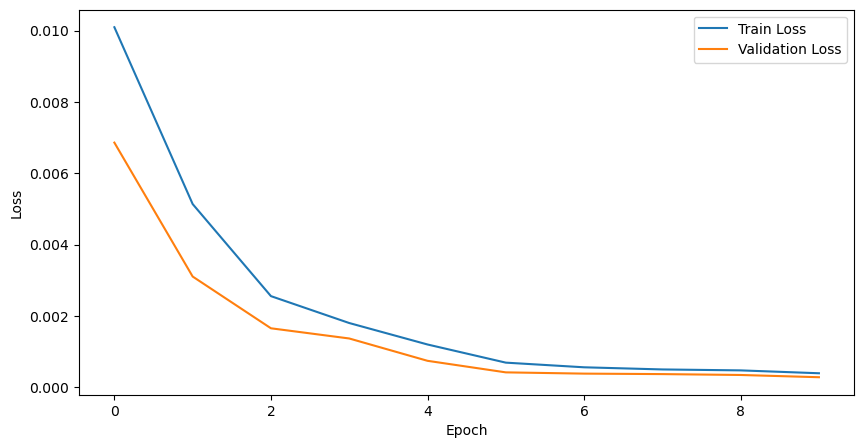

100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.26it/s]


Epoch 1/10, Train Loss: 0.0055, Val Loss: 0.0040


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.49it/s]


Epoch 2/10, Train Loss: 0.0029, Val Loss: 0.0023


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.37it/s]


Epoch 3/10, Train Loss: 0.0015, Val Loss: 0.0012


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.52it/s]


Epoch 4/10, Train Loss: 0.0009, Val Loss: 0.0007


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.62it/s]


Epoch 5/10, Train Loss: 0.0006, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.99it/s]


Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.87it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.56it/s]


Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.40it/s]


Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.24it/s]


Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


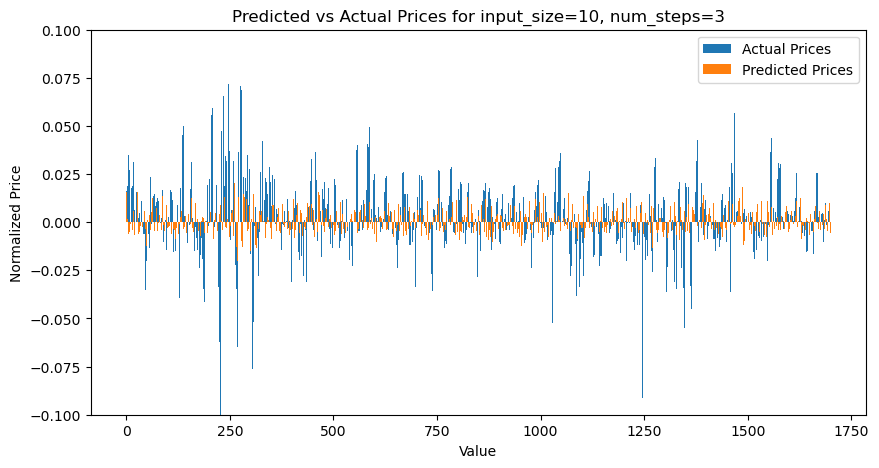

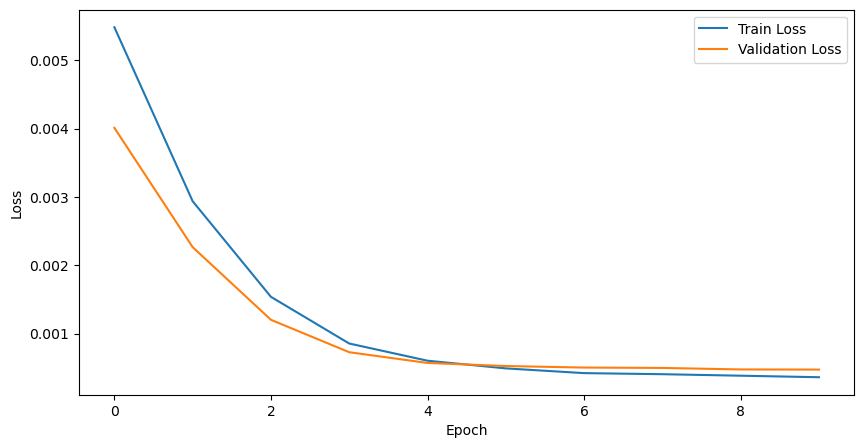

100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.72it/s]


Epoch 1/10, Train Loss: 0.0039, Val Loss: 0.0027


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.09it/s]


Epoch 2/10, Train Loss: 0.0020, Val Loss: 0.0013


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.10it/s]


Epoch 3/10, Train Loss: 0.0011, Val Loss: 0.0008


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.21it/s]


Epoch 4/10, Train Loss: 0.0007, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.17it/s]


Epoch 5/10, Train Loss: 0.0006, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.94it/s]


Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.68it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.56it/s]


Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.79it/s]


Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.97it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


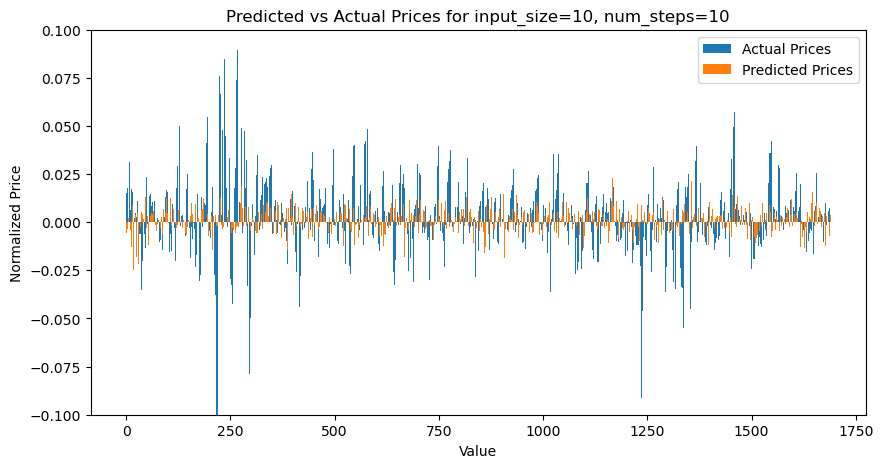

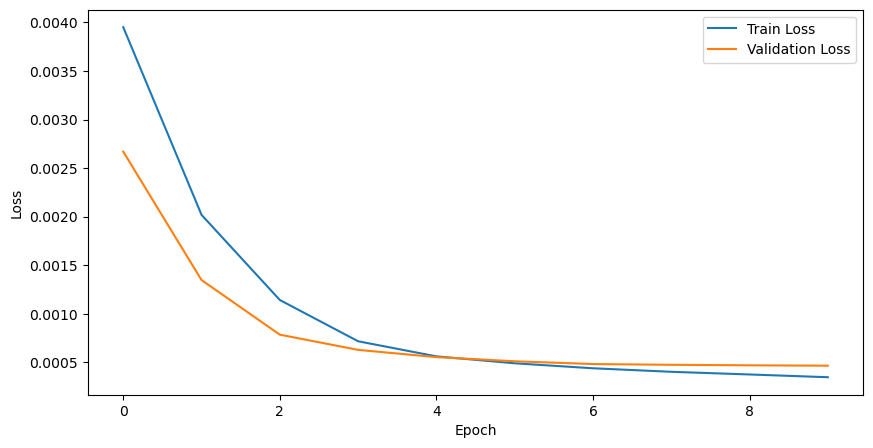

100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.83it/s]


Epoch 1/10, Train Loss: 0.0090, Val Loss: 0.0061


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.70it/s]


Epoch 2/10, Train Loss: 0.0051, Val Loss: 0.0032


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.77it/s]


Epoch 3/10, Train Loss: 0.0025, Val Loss: 0.0016


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.84it/s]


Epoch 4/10, Train Loss: 0.0013, Val Loss: 0.0008


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.96it/s]


Epoch 5/10, Train Loss: 0.0010, Val Loss: 0.0006


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.94it/s]


Epoch 6/10, Train Loss: 0.0008, Val Loss: 0.0006


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.06it/s]


Epoch 7/10, Train Loss: 0.0006, Val Loss: 0.0006


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  7.00it/s]


Epoch 8/10, Train Loss: 0.0005, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.88it/s]


Epoch 9/10, Train Loss: 0.0005, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.90it/s]


Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


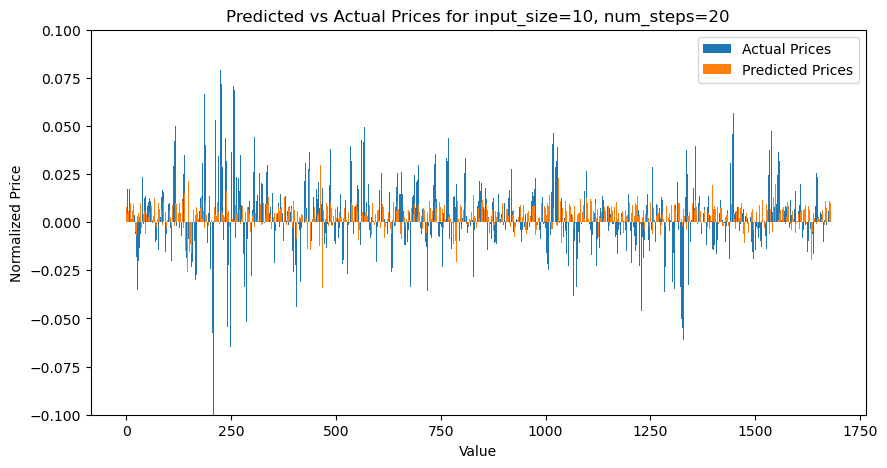

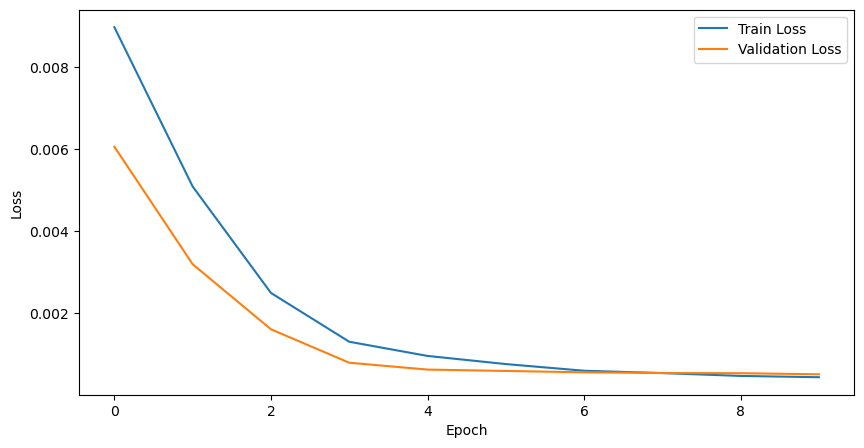

100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.43it/s]


Epoch 1/10, Train Loss: 0.0086, Val Loss: 0.0073


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.49it/s]


Epoch 2/10, Train Loss: 0.0065, Val Loss: 0.0055


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.50it/s]


Epoch 3/10, Train Loss: 0.0049, Val Loss: 0.0042


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.28it/s]


Epoch 4/10, Train Loss: 0.0036, Val Loss: 0.0030


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.27it/s]


Epoch 5/10, Train Loss: 0.0027, Val Loss: 0.0023


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.39it/s]


Epoch 6/10, Train Loss: 0.0020, Val Loss: 0.0018


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.48it/s]


Epoch 7/10, Train Loss: 0.0016, Val Loss: 0.0013


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.49it/s]


Epoch 8/10, Train Loss: 0.0012, Val Loss: 0.0010


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.54it/s]


Epoch 9/10, Train Loss: 0.0009, Val Loss: 0.0008


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.41it/s]


Epoch 10/10, Train Loss: 0.0008, Val Loss: 0.0007
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


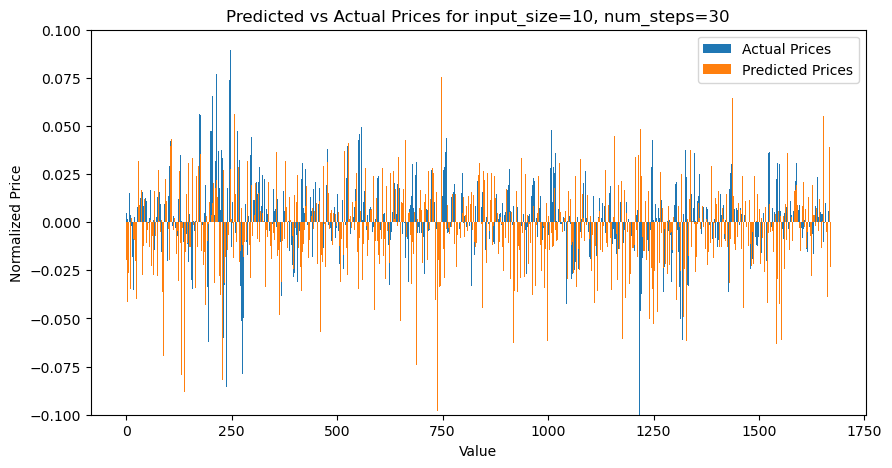

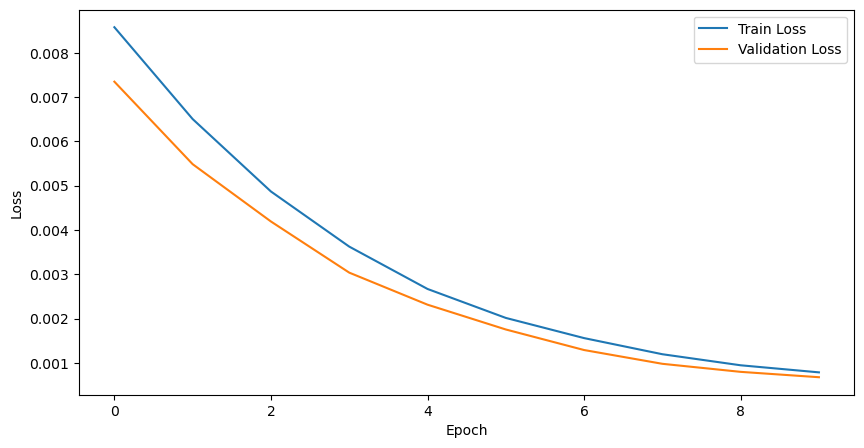

100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 1/10, Train Loss: 0.0060, Val Loss: 0.0046


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.59it/s]


Epoch 2/10, Train Loss: 0.0048, Val Loss: 0.0040


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.58it/s]


Epoch 3/10, Train Loss: 0.0041, Val Loss: 0.0032


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.50it/s]


Epoch 4/10, Train Loss: 0.0030, Val Loss: 0.0024


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.46it/s]


Epoch 5/10, Train Loss: 0.0023, Val Loss: 0.0021


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.55it/s]


Epoch 6/10, Train Loss: 0.0018, Val Loss: 0.0016


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.21it/s]


Epoch 7/10, Train Loss: 0.0015, Val Loss: 0.0014


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.50it/s]


Epoch 8/10, Train Loss: 0.0013, Val Loss: 0.0013


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch 9/10, Train Loss: 0.0012, Val Loss: 0.0011


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 10/10, Train Loss: 0.0010, Val Loss: 0.0010
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


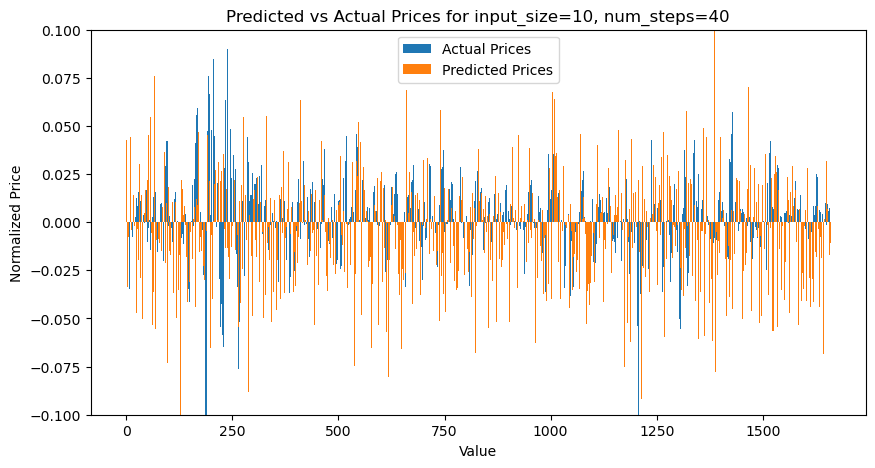

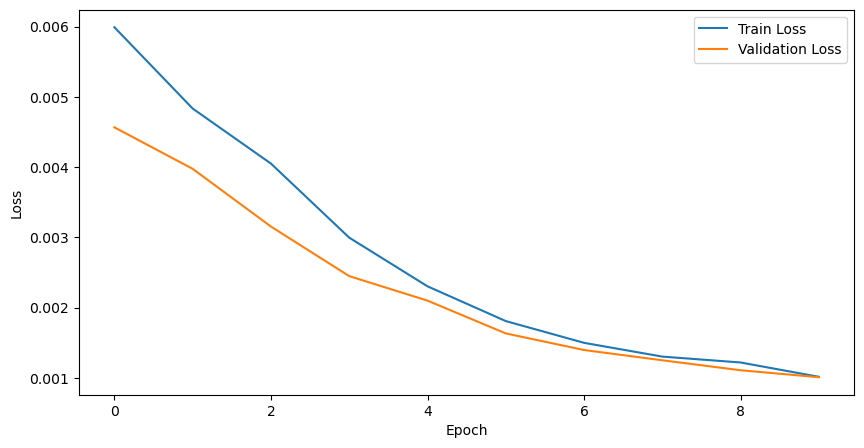

100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.82it/s]


Epoch 1/10, Train Loss: 0.0085, Val Loss: 0.0075


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.93it/s]


Epoch 2/10, Train Loss: 0.0071, Val Loss: 0.0063


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.87it/s]


Epoch 3/10, Train Loss: 0.0058, Val Loss: 0.0051


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.91it/s]


Epoch 4/10, Train Loss: 0.0050, Val Loss: 0.0043


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.77it/s]


Epoch 5/10, Train Loss: 0.0040, Val Loss: 0.0032


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.94it/s]


Epoch 6/10, Train Loss: 0.0032, Val Loss: 0.0025


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.94it/s]


Epoch 7/10, Train Loss: 0.0026, Val Loss: 0.0022


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.88it/s]


Epoch 8/10, Train Loss: 0.0021, Val Loss: 0.0016


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.86it/s]


Epoch 9/10, Train Loss: 0.0018, Val Loss: 0.0016


100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.94it/s]


Epoch 10/10, Train Loss: 0.0014, Val Loss: 0.0011
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


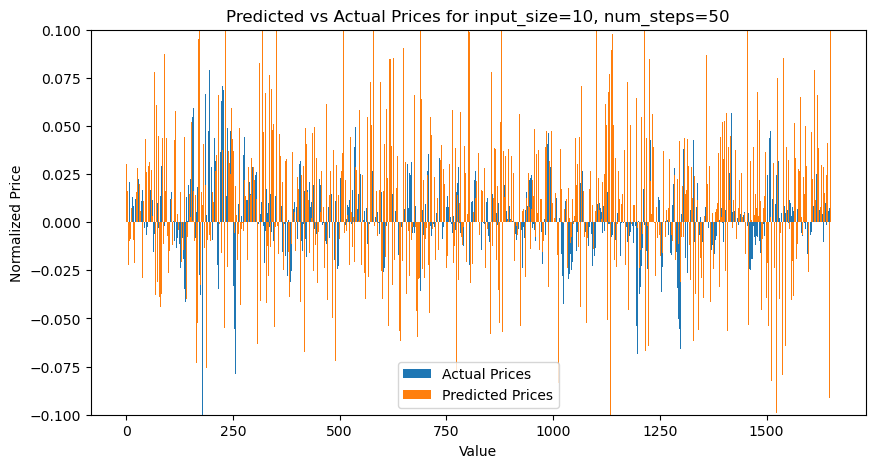

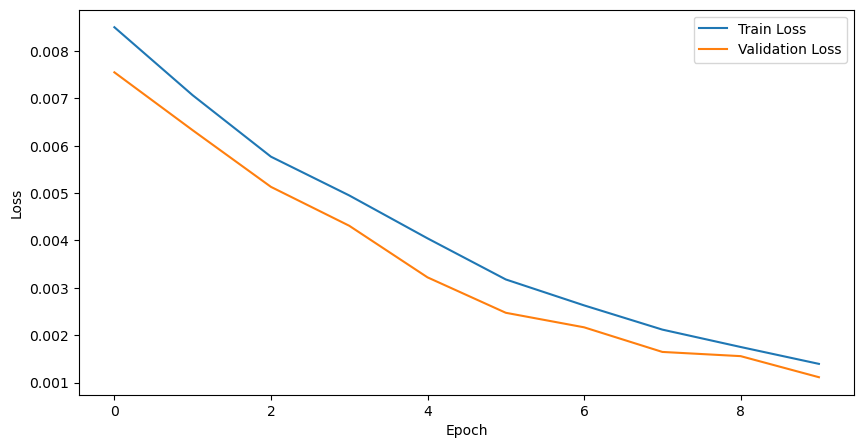

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.54it/s]


Epoch 1/10, Train Loss: 0.0090, Val Loss: 0.0079


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.13it/s]


Epoch 2/10, Train Loss: 0.0077, Val Loss: 0.0069


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.79it/s]


Epoch 3/10, Train Loss: 0.0067, Val Loss: 0.0062


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.78it/s]


Epoch 4/10, Train Loss: 0.0059, Val Loss: 0.0056


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.80it/s]


Epoch 5/10, Train Loss: 0.0052, Val Loss: 0.0048


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.27it/s]


Epoch 6/10, Train Loss: 0.0044, Val Loss: 0.0041


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.07it/s]


Epoch 7/10, Train Loss: 0.0039, Val Loss: 0.0036


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.15it/s]


Epoch 8/10, Train Loss: 0.0034, Val Loss: 0.0032


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.25it/s]


Epoch 9/10, Train Loss: 0.0031, Val Loss: 0.0028


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.18it/s]


Epoch 10/10, Train Loss: 0.0028, Val Loss: 0.0025
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


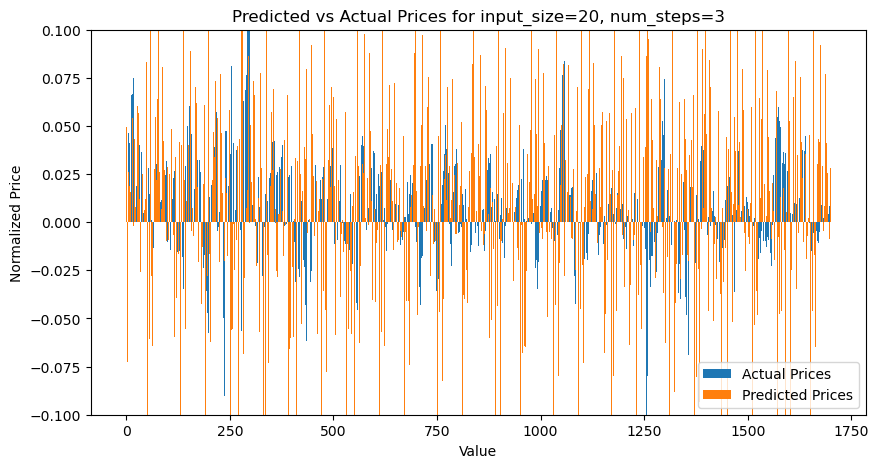

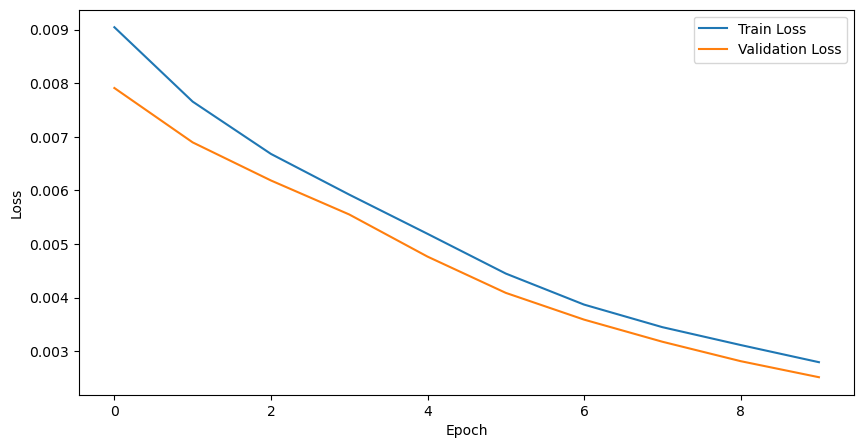

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.90it/s]


Epoch 1/10, Train Loss: 0.0095, Val Loss: 0.0082


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.45it/s]


Epoch 2/10, Train Loss: 0.0081, Val Loss: 0.0071


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.85it/s]


Epoch 3/10, Train Loss: 0.0070, Val Loss: 0.0064


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.87it/s]


Epoch 4/10, Train Loss: 0.0064, Val Loss: 0.0060


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.08it/s]


Epoch 5/10, Train Loss: 0.0058, Val Loss: 0.0055


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.08it/s]


Epoch 6/10, Train Loss: 0.0054, Val Loss: 0.0052


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.98it/s]


Epoch 7/10, Train Loss: 0.0050, Val Loss: 0.0048


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.86it/s]


Epoch 8/10, Train Loss: 0.0046, Val Loss: 0.0045


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.00it/s]


Epoch 9/10, Train Loss: 0.0043, Val Loss: 0.0041


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.87it/s]


Epoch 10/10, Train Loss: 0.0040, Val Loss: 0.0038
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


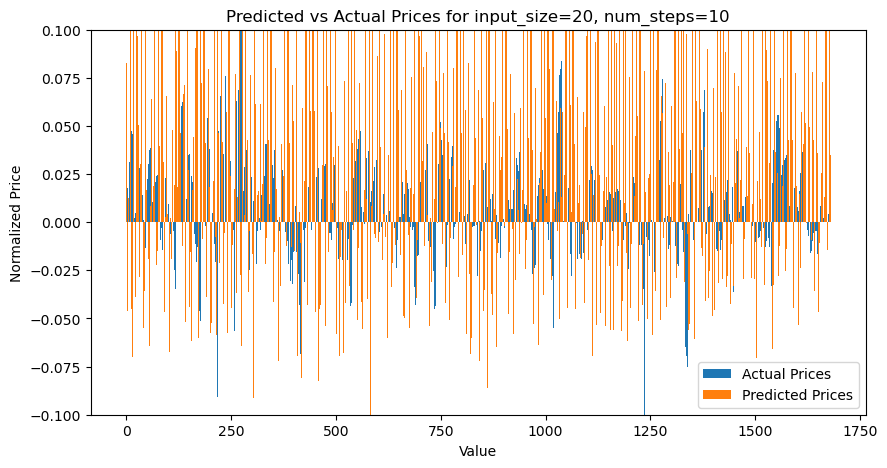

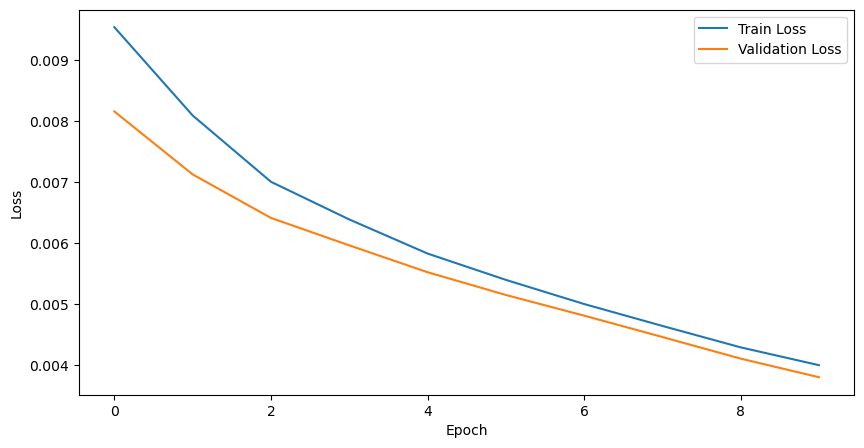

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.77it/s]


Epoch 1/10, Train Loss: 0.0104, Val Loss: 0.0088


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.93it/s]


Epoch 2/10, Train Loss: 0.0085, Val Loss: 0.0076


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.01it/s]


Epoch 3/10, Train Loss: 0.0068, Val Loss: 0.0059


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.01it/s]


Epoch 4/10, Train Loss: 0.0056, Val Loss: 0.0048


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.98it/s]


Epoch 5/10, Train Loss: 0.0045, Val Loss: 0.0037


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.85it/s]


Epoch 6/10, Train Loss: 0.0037, Val Loss: 0.0031


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.80it/s]


Epoch 7/10, Train Loss: 0.0030, Val Loss: 0.0025


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.78it/s]


Epoch 8/10, Train Loss: 0.0025, Val Loss: 0.0022


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.55it/s]


Epoch 9/10, Train Loss: 0.0022, Val Loss: 0.0018


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.54it/s]


Epoch 10/10, Train Loss: 0.0019, Val Loss: 0.0016
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


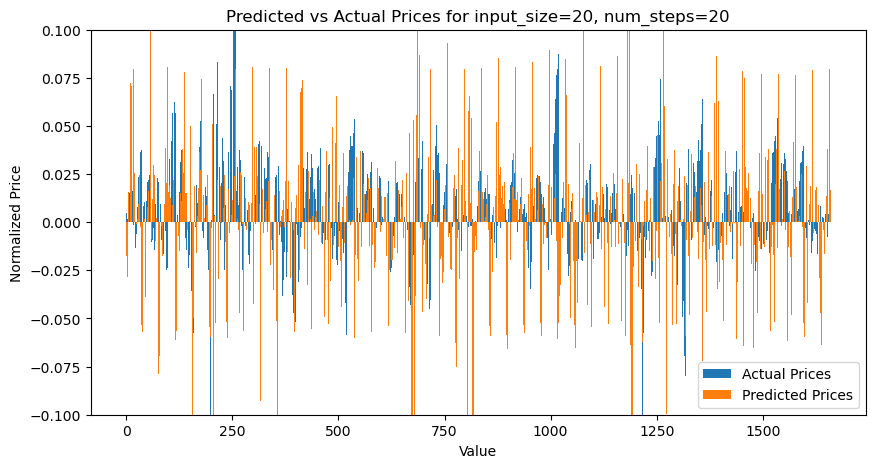

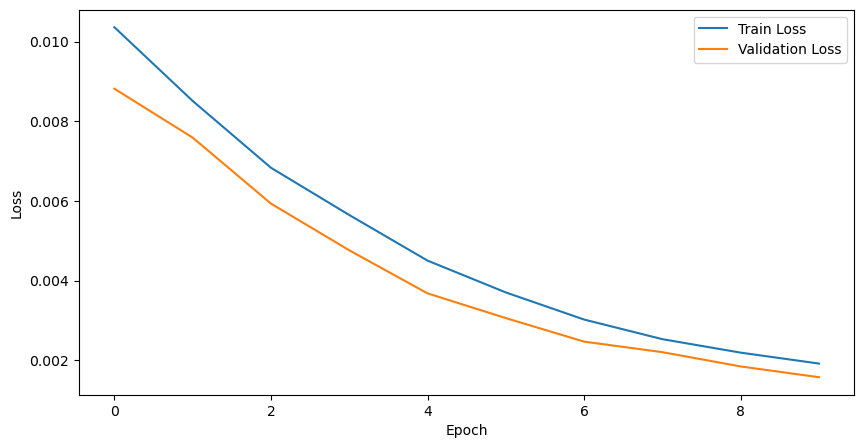

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.05it/s]


Epoch 1/10, Train Loss: 0.0090, Val Loss: 0.0083


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.09it/s]


Epoch 2/10, Train Loss: 0.0078, Val Loss: 0.0068


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.20it/s]


Epoch 3/10, Train Loss: 0.0066, Val Loss: 0.0058


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  3.94it/s]


Epoch 4/10, Train Loss: 0.0057, Val Loss: 0.0050


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.11it/s]


Epoch 5/10, Train Loss: 0.0049, Val Loss: 0.0045


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.12it/s]


Epoch 6/10, Train Loss: 0.0043, Val Loss: 0.0037


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.07it/s]


Epoch 7/10, Train Loss: 0.0038, Val Loss: 0.0033


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.19it/s]


Epoch 8/10, Train Loss: 0.0032, Val Loss: 0.0026


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.17it/s]


Epoch 9/10, Train Loss: 0.0027, Val Loss: 0.0022


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.10it/s]


Epoch 10/10, Train Loss: 0.0024, Val Loss: 0.0019
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


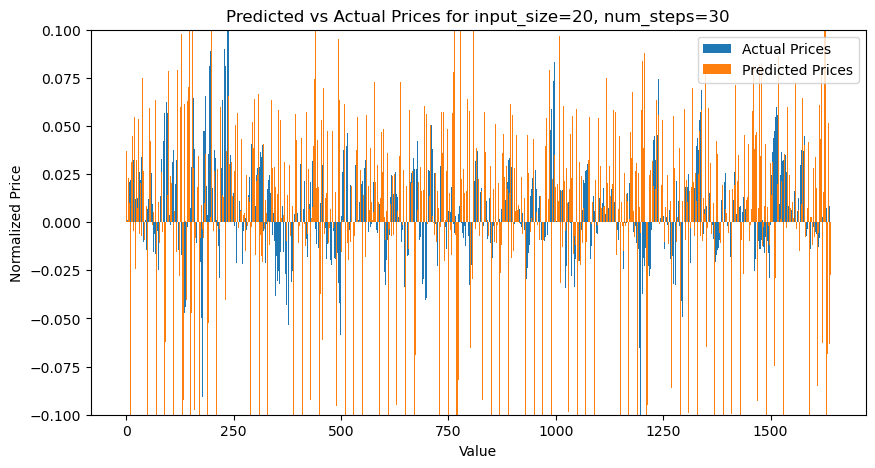

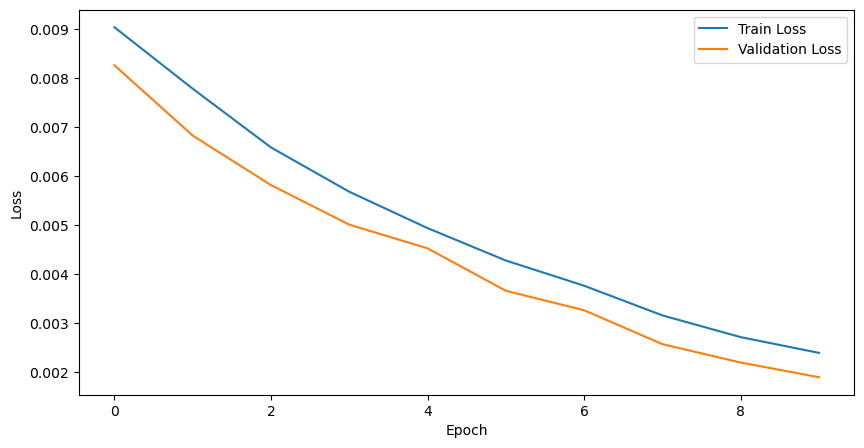

100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.53it/s]


Epoch 1/10, Train Loss: 0.0086, Val Loss: 0.0076


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.28it/s]


Epoch 2/10, Train Loss: 0.0079, Val Loss: 0.0070


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.58it/s]


Epoch 3/10, Train Loss: 0.0070, Val Loss: 0.0063


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.61it/s]


Epoch 4/10, Train Loss: 0.0064, Val Loss: 0.0055


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.58it/s]


Epoch 5/10, Train Loss: 0.0059, Val Loss: 0.0048


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.60it/s]


Epoch 6/10, Train Loss: 0.0053, Val Loss: 0.0045


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.52it/s]


Epoch 7/10, Train Loss: 0.0047, Val Loss: 0.0040


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.50it/s]


Epoch 8/10, Train Loss: 0.0040, Val Loss: 0.0033


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


Epoch 9/10, Train Loss: 0.0036, Val Loss: 0.0030


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.51it/s]


Epoch 10/10, Train Loss: 0.0033, Val Loss: 0.0028
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


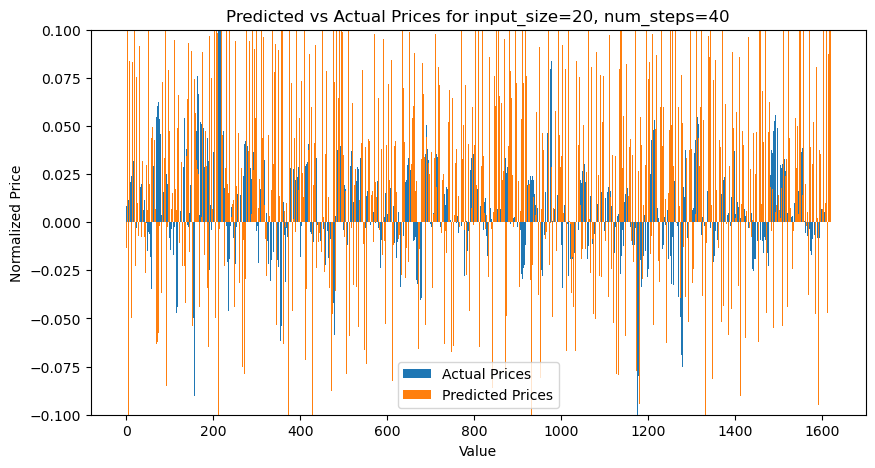

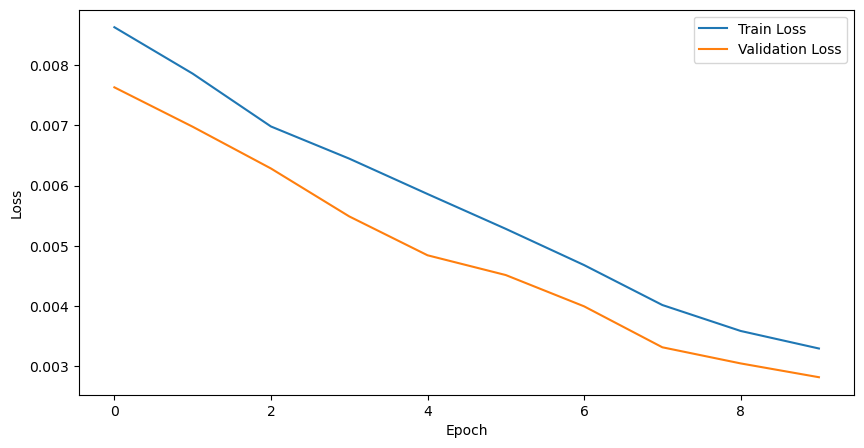

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.78it/s]


Epoch 1/10, Train Loss: 0.0160, Val Loss: 0.0152


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch 2/10, Train Loss: 0.0151, Val Loss: 0.0141


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.91it/s]


Epoch 3/10, Train Loss: 0.0142, Val Loss: 0.0136


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 4/10, Train Loss: 0.0135, Val Loss: 0.0127


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch 5/10, Train Loss: 0.0127, Val Loss: 0.0119


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch 6/10, Train Loss: 0.0122, Val Loss: 0.0117


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch 7/10, Train Loss: 0.0115, Val Loss: 0.0108


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]


Epoch 8/10, Train Loss: 0.0109, Val Loss: 0.0104


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch 9/10, Train Loss: 0.0104, Val Loss: 0.0098


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch 10/10, Train Loss: 0.0098, Val Loss: 0.0094
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


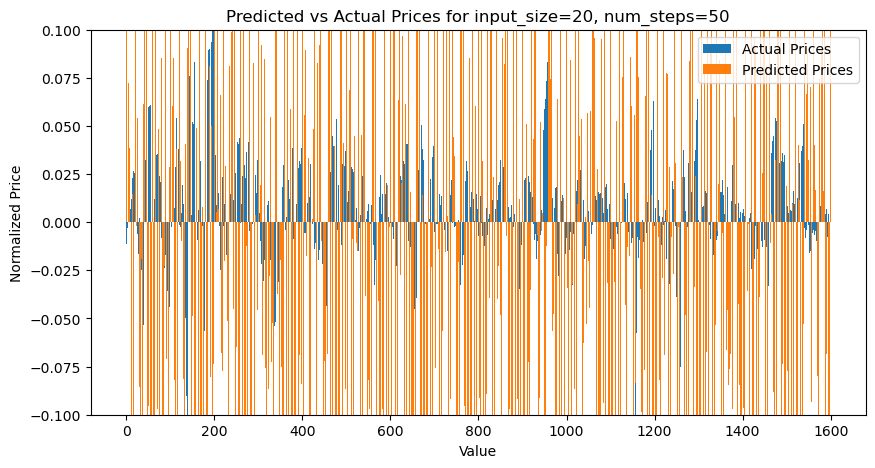

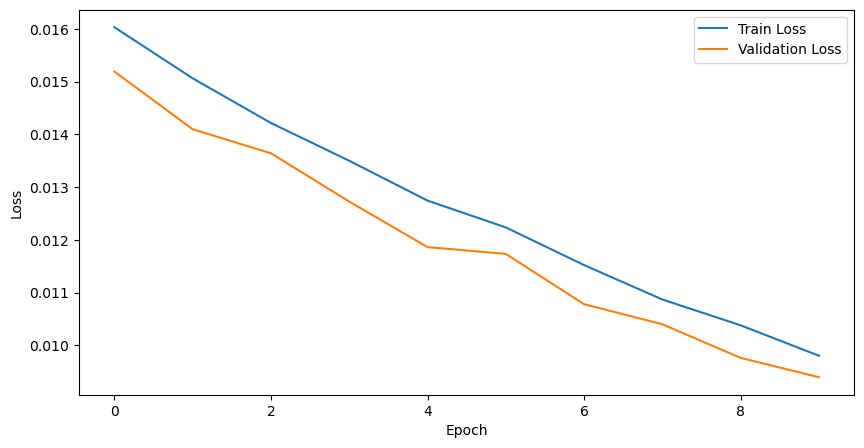

Unnamed: 0                 18.000000
Input Size                 10.000000
Number of Steps             3.000000
Test Loss                   0.000655
Classification Accuracy     0.479412
Duration                   30.473838
Name: 18, dtype: float64


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [26]:
# LSTM (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'lstm'
SEARCH_NEEDED_LSTM = False
df_best_model = get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=SEARCH_NEEDED_LSTM)

In [28]:
df_best_model

Unnamed: 0                 18.000000
Input Size                 10.000000
Number of Steps             3.000000
Test Loss                   0.000655
Classification Accuracy     0.479412
Duration                   30.473838
Name: 18, dtype: float64

100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  7.44it/s]


Epoch 1/10, Train Loss: 0.0056, Val Loss: 0.0043


100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.96it/s]


Epoch 2/10, Train Loss: 0.0030, Val Loss: 0.0023


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.52it/s]


Epoch 3/10, Train Loss: 0.0016, Val Loss: 0.0013


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.63it/s]


Epoch 4/10, Train Loss: 0.0009, Val Loss: 0.0008


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.99it/s]


Epoch 5/10, Train Loss: 0.0006, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.59it/s]


Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.13it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.90it/s]


Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.21it/s]


Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.34it/s]


Epoch 10/10, Train Loss: 0.0004, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomLSTMCell(
      (ln_i): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


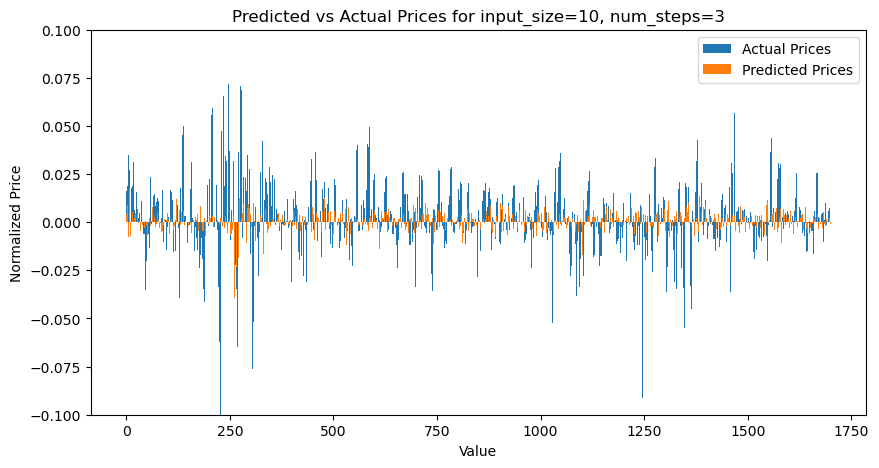

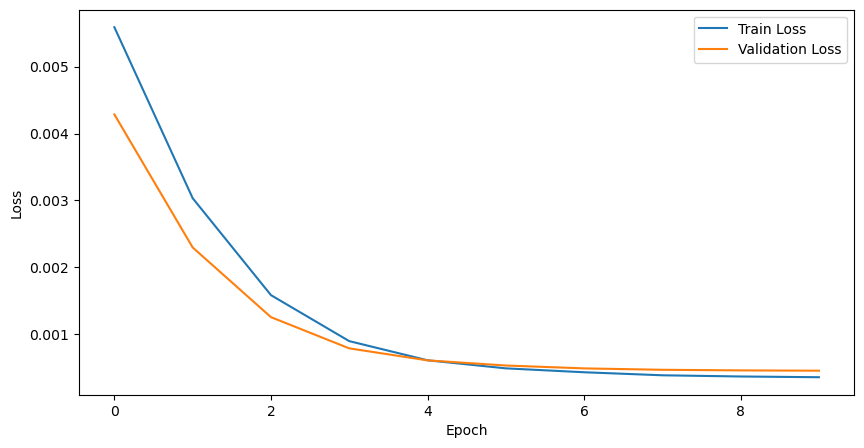

Test loss of best model: 0.0006229653372429311
Classification accuracy of best model: 0.5029411764705882
Duration of best model: 34.95872616767883


In [29]:
# Modify the input_size and num_steps attributes
data_preparation = DataPreparation(dataset_name, num_steps=int(df_best_model['Number of Steps']), input_size=int(df_best_model['Input Size']))

# Train & Evaluate model
evaluation_results = TrainAndPredict(data_preparation, cell_type, train_needed=True)
print("Test loss of best model:", evaluation_results.test_loss)
print("Classification accuracy of best model:", evaluation_results.classification_accuracy)
print("Duration of best model:", evaluation_results.duration)

100%|█████████████████████████████████████████| 107/107 [00:03<00:00, 35.63it/s]


Epoch 1/10, Train Loss: 0.0013, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 41.58it/s]


Epoch 2/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 43.00it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 39.70it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:03<00:00, 35.16it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 39.49it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 43.32it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 45.44it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 45.71it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 107/107 [00:02<00:00, 46.68it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


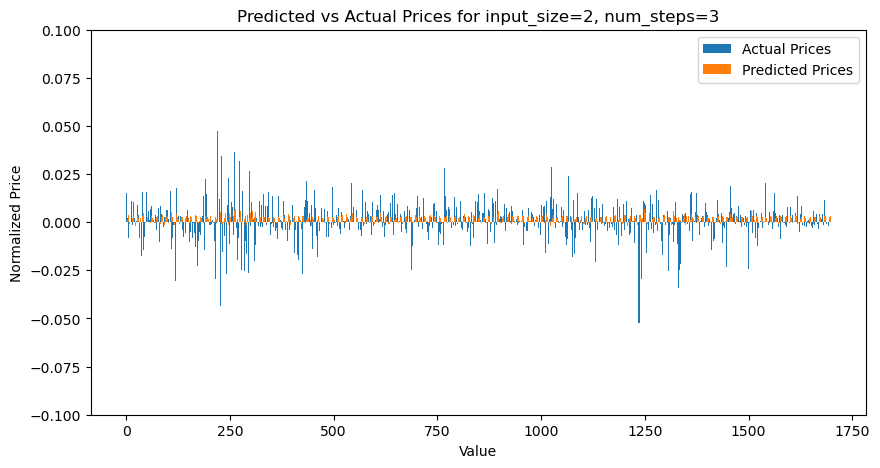

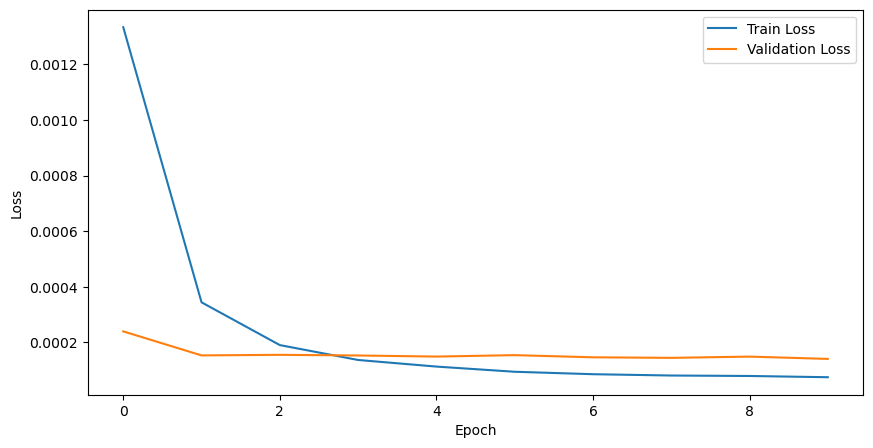

100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 22.11it/s]


Epoch 1/10, Train Loss: 0.0026, Val Loss: 0.0003


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 22.33it/s]


Epoch 2/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 23.83it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 24.11it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 22.33it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 23.34it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 23.92it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 24.48it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 24.58it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:04<00:00, 22.63it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


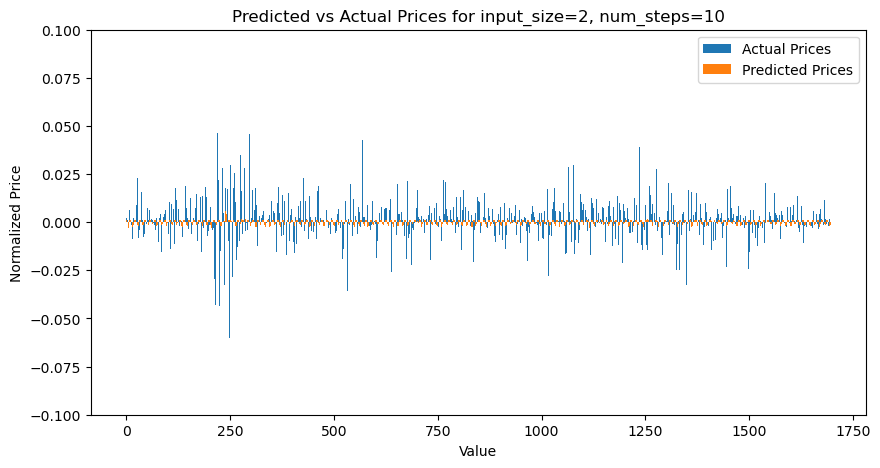

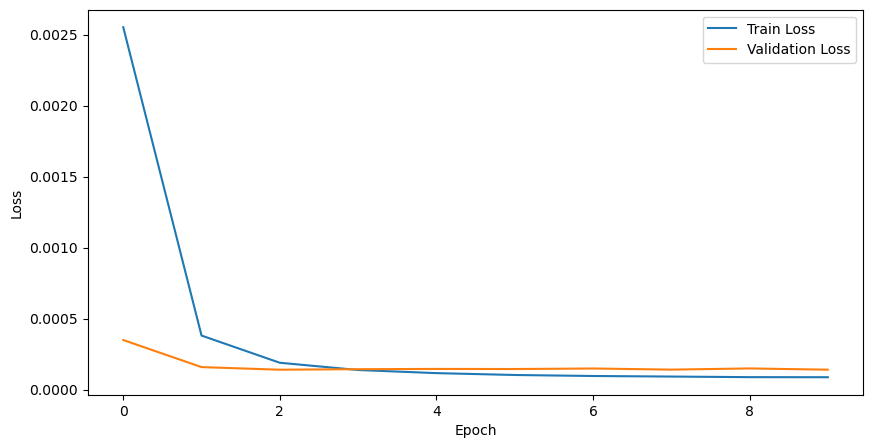

100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.05it/s]


Epoch 1/10, Train Loss: 0.0021, Val Loss: 0.0003


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.58it/s]


Epoch 2/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.65it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.44it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.92it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.77it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.62it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.21it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.48it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:07<00:00, 14.53it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


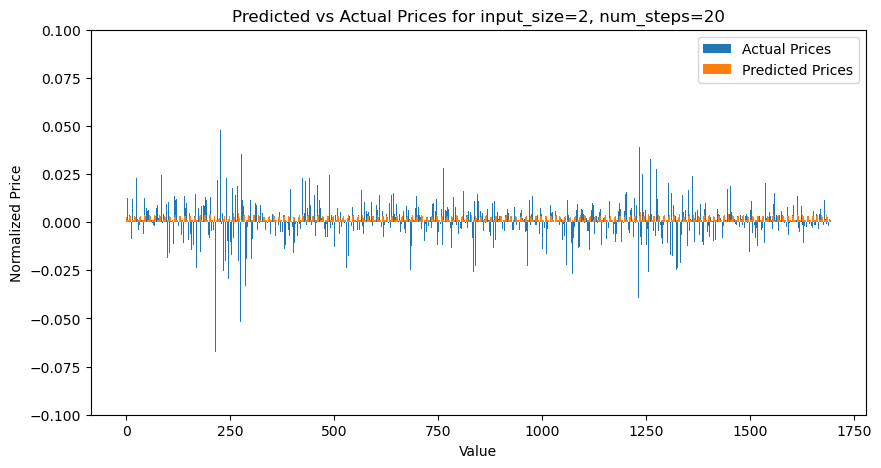

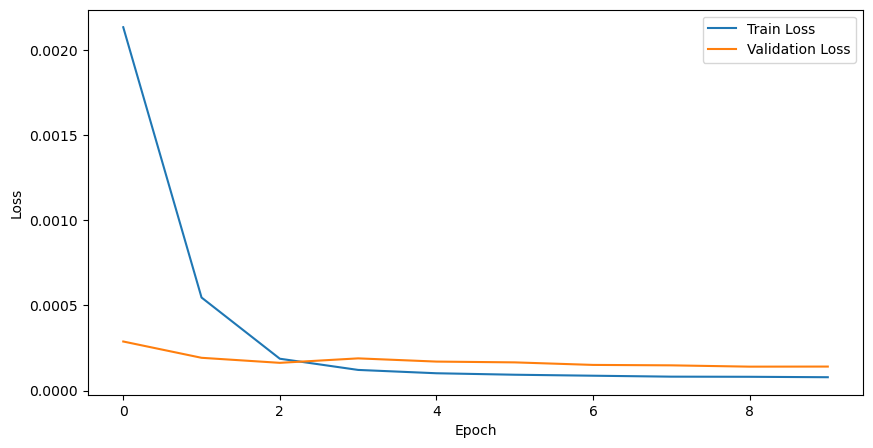

100%|█████████████████████████████████████████| 106/106 [00:10<00:00, 10.32it/s]


Epoch 1/10, Train Loss: 0.0024, Val Loss: 0.0003


100%|█████████████████████████████████████████| 106/106 [00:10<00:00, 10.46it/s]


Epoch 2/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 10.67it/s]


Epoch 3/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:10<00:00, 10.49it/s]


Epoch 4/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 10.65it/s]


Epoch 5/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 10.73it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 10.60it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:10<00:00, 10.46it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:10<00:00, 10.50it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:09<00:00, 10.67it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


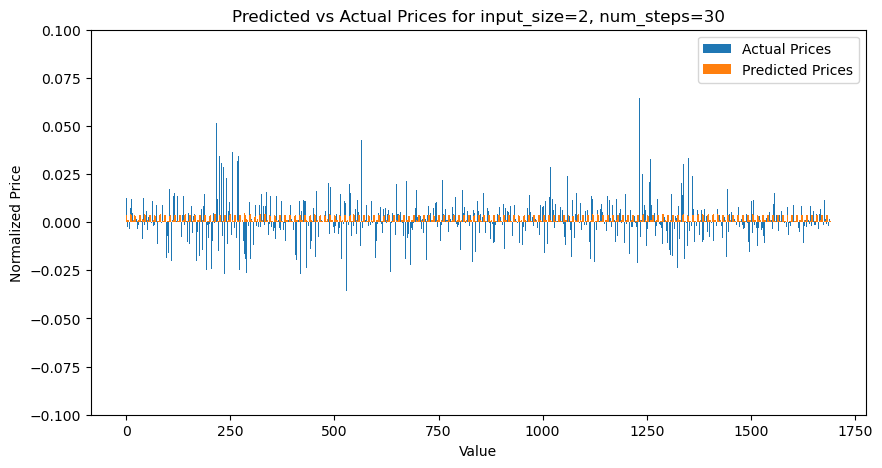

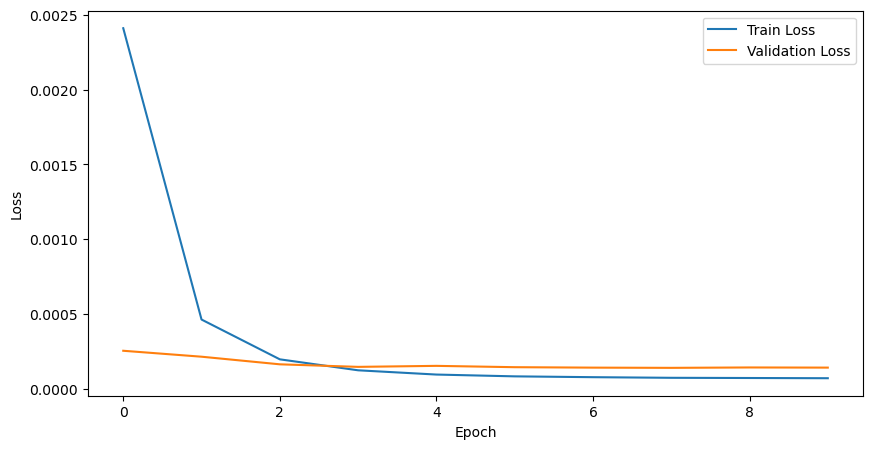

100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.15it/s]


Epoch 1/10, Train Loss: 0.0037, Val Loss: 0.0003


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.15it/s]


Epoch 2/10, Train Loss: 0.0007, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.20it/s]


Epoch 3/10, Train Loss: 0.0003, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.19it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  8.15it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.21it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:12<00:00,  8.36it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  7.77it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  7.87it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:13<00:00,  7.94it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0001
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


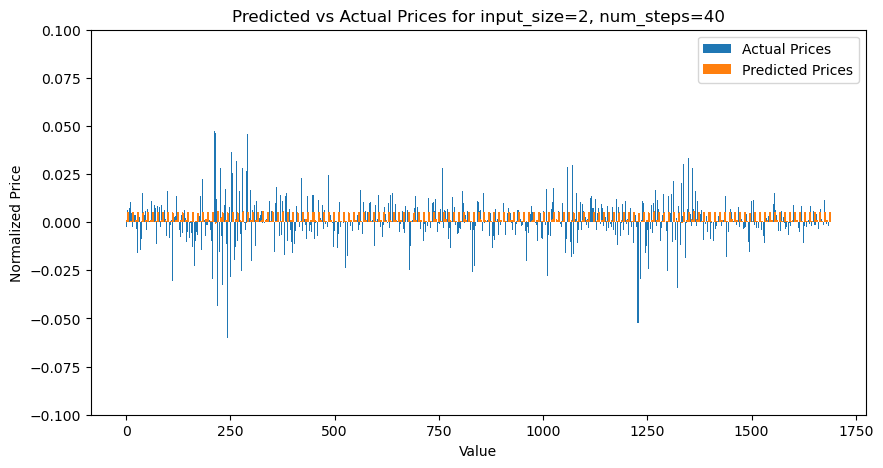

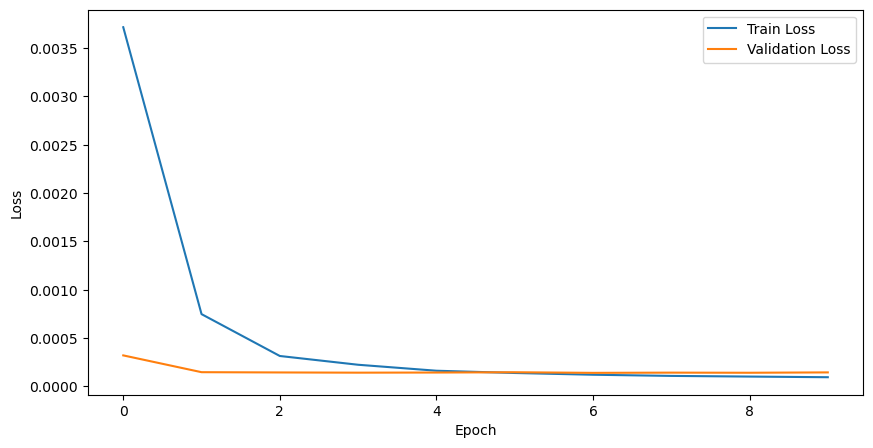

100%|█████████████████████████████████████████| 106/106 [00:16<00:00,  6.52it/s]


Epoch 1/10, Train Loss: 0.0033, Val Loss: 0.0005


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.64it/s]


Epoch 2/10, Train Loss: 0.0012, Val Loss: 0.0003


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.68it/s]


Epoch 3/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.73it/s]


Epoch 4/10, Train Loss: 0.0003, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.72it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.67it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.69it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.79it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.80it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0001


100%|█████████████████████████████████████████| 106/106 [00:15<00:00,  6.64it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=2, bias=True)
)


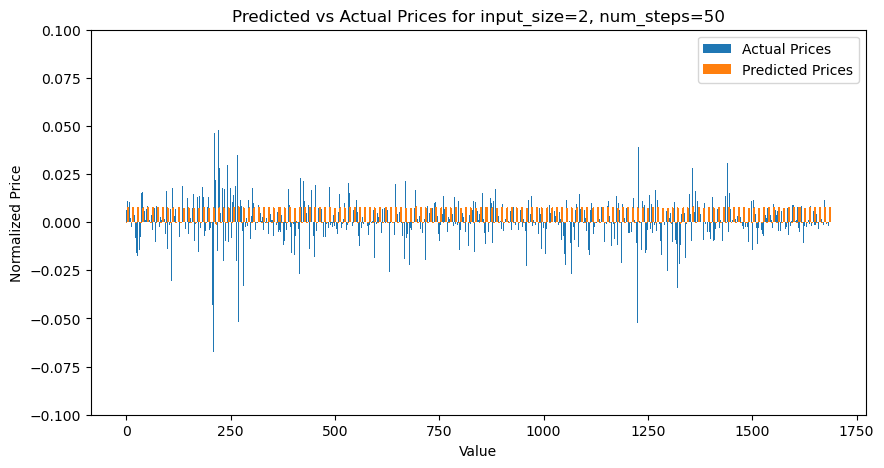

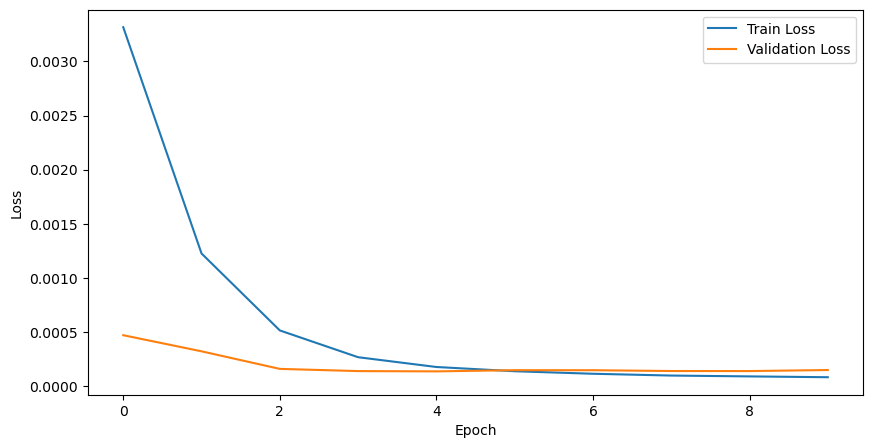

100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 32.71it/s]


Epoch 1/10, Train Loss: 0.0014, Val Loss: 0.0004


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 34.89it/s]


Epoch 2/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 33.44it/s]


Epoch 3/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 34.65it/s]


Epoch 4/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 35.48it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:01<00:00, 36.63it/s]


Epoch 6/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 34.87it/s]


Epoch 7/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:01<00:00, 36.15it/s]


Epoch 8/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:02<00:00, 33.79it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:01<00:00, 36.55it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


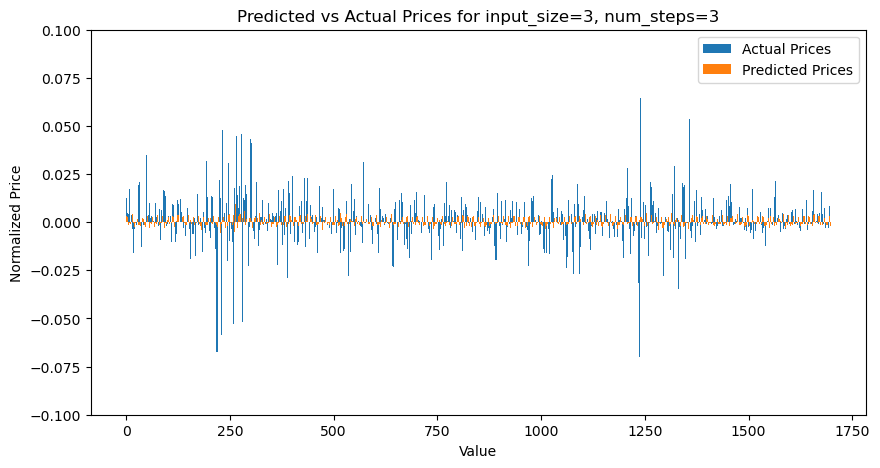

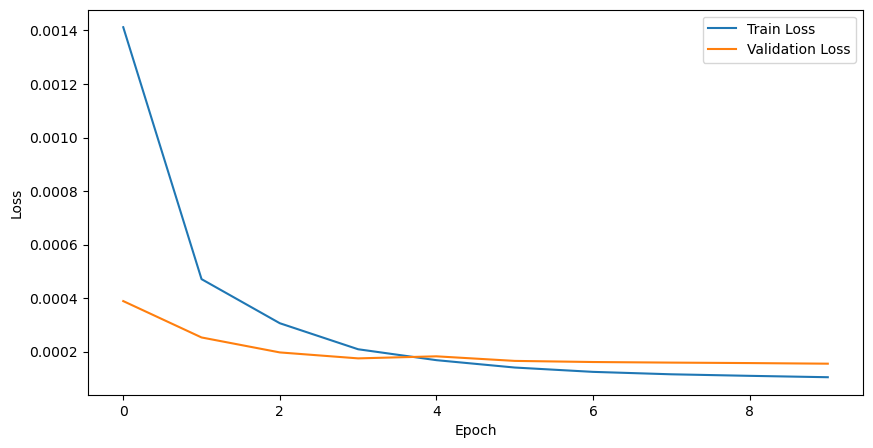

100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 20.94it/s]


Epoch 1/10, Train Loss: 0.0033, Val Loss: 0.0004


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 21.05it/s]


Epoch 2/10, Train Loss: 0.0007, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 21.37it/s]


Epoch 3/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 20.56it/s]


Epoch 4/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 20.94it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 21.21it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 20.57it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 21.31it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 21.45it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:03<00:00, 21.42it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


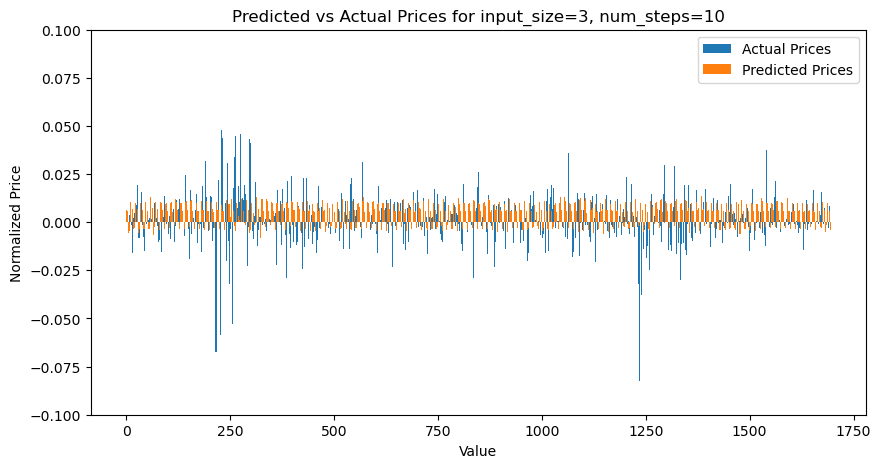

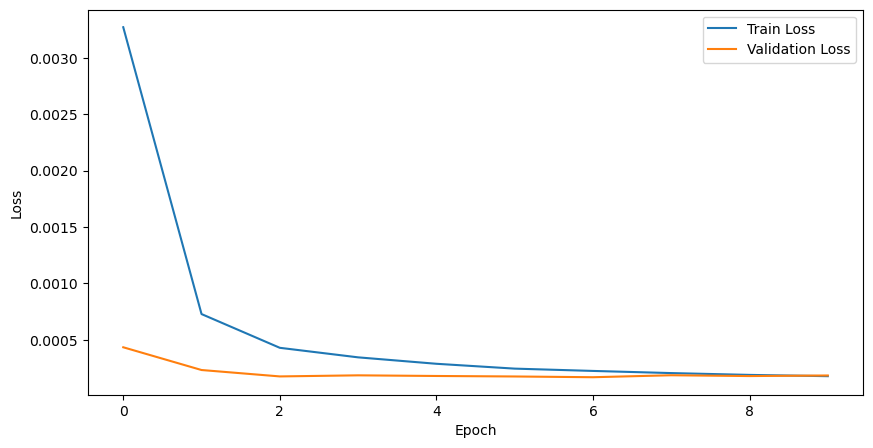

100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.54it/s]


Epoch 1/10, Train Loss: 0.0049, Val Loss: 0.0007


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.41it/s]


Epoch 2/10, Train Loss: 0.0013, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 12.99it/s]


Epoch 3/10, Train Loss: 0.0008, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.55it/s]


Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.26it/s]


Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.33it/s]


Epoch 6/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.39it/s]


Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.62it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.67it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:05<00:00, 13.39it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


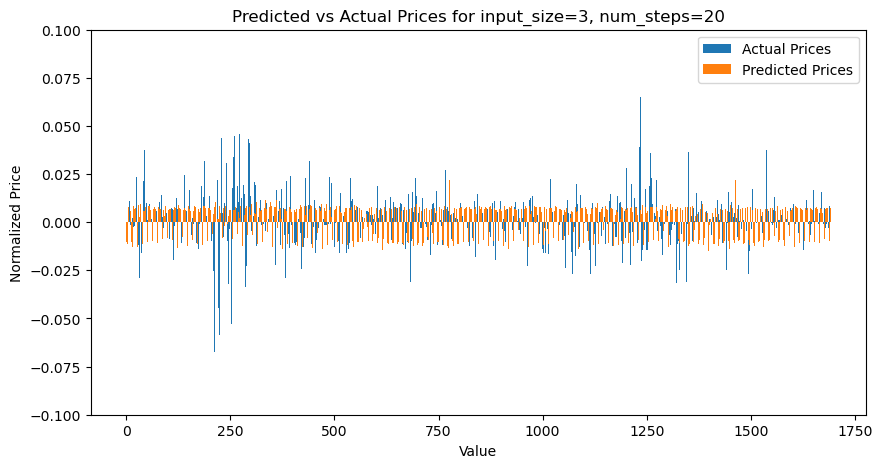

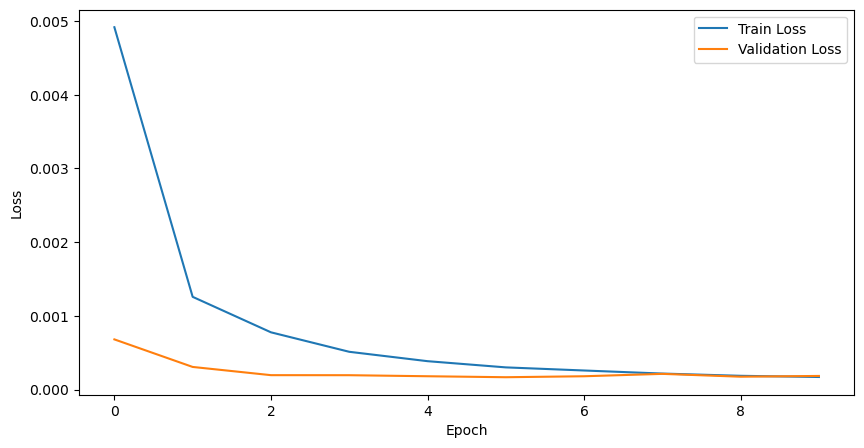

100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.77it/s]


Epoch 1/10, Train Loss: 0.0091, Val Loss: 0.0012


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.40it/s]


Epoch 2/10, Train Loss: 0.0016, Val Loss: 0.0006


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.64it/s]


Epoch 3/10, Train Loss: 0.0008, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.92it/s]


Epoch 4/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00, 10.01it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.78it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.95it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.96it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.82it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.92it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


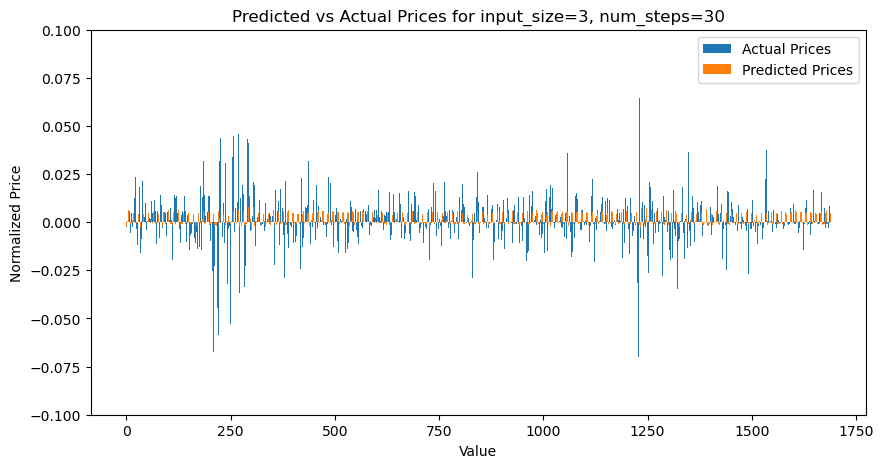

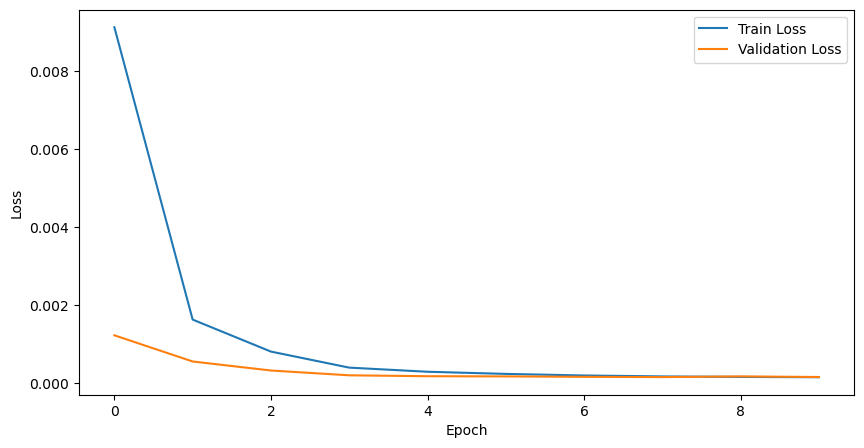

100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.69it/s]


Epoch 1/10, Train Loss: 0.0050, Val Loss: 0.0007


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.87it/s]


Epoch 2/10, Train Loss: 0.0012, Val Loss: 0.0004


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.66it/s]


Epoch 3/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.63it/s]


Epoch 4/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.77it/s]


Epoch 5/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.57it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:08<00:00,  7.90it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.70it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.75it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:09<00:00,  7.84it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


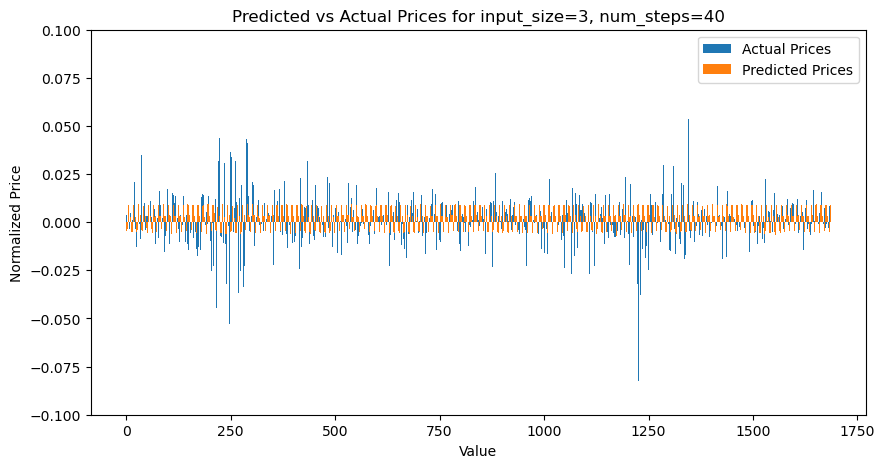

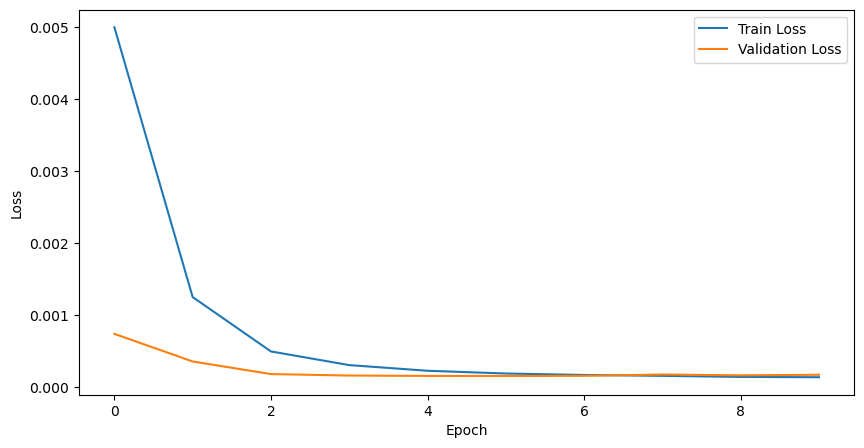

100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.24it/s]


Epoch 1/10, Train Loss: 0.0071, Val Loss: 0.0017


100%|███████████████████████████████████████████| 71/71 [00:10<00:00,  6.49it/s]


Epoch 2/10, Train Loss: 0.0019, Val Loss: 0.0006


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.44it/s]


Epoch 3/10, Train Loss: 0.0011, Val Loss: 0.0003


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.45it/s]


Epoch 4/10, Train Loss: 0.0006, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:10<00:00,  6.50it/s]


Epoch 5/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.40it/s]


Epoch 6/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:10<00:00,  6.53it/s]


Epoch 7/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:10<00:00,  6.53it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:10<00:00,  6.48it/s]


Epoch 9/10, Train Loss: 0.0001, Val Loss: 0.0002


100%|███████████████████████████████████████████| 71/71 [00:11<00:00,  6.34it/s]


Epoch 10/10, Train Loss: 0.0001, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)


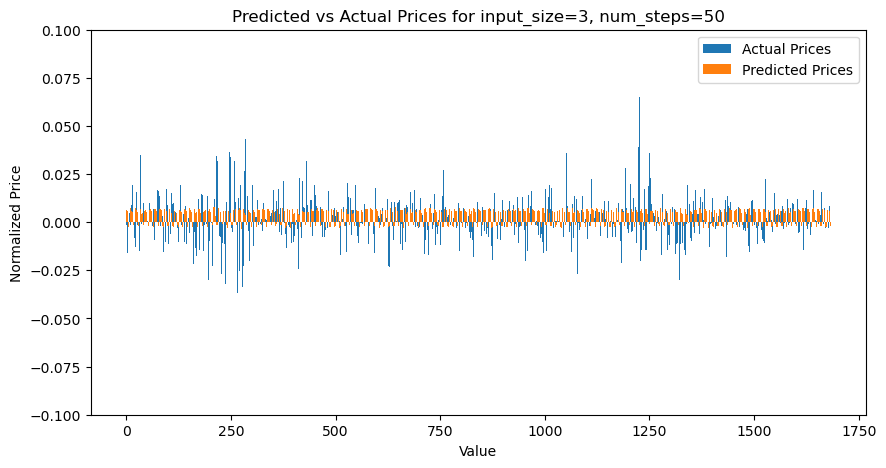

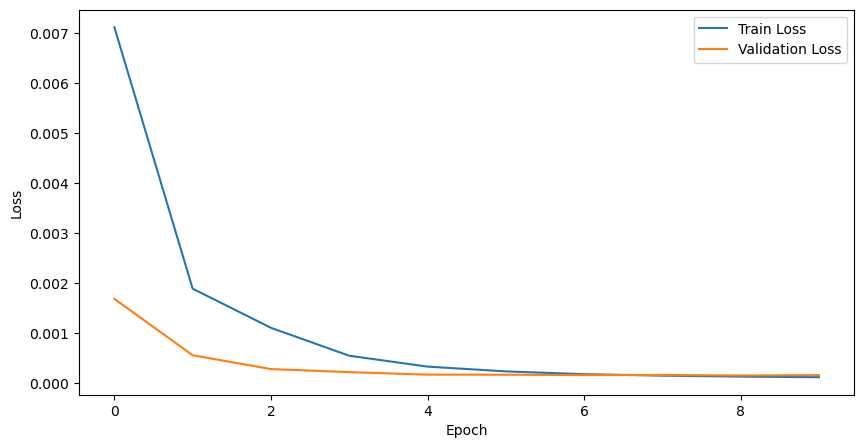

100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 24.12it/s]


Epoch 1/10, Train Loss: 0.0118, Val Loss: 0.0047


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.15it/s]


Epoch 2/10, Train Loss: 0.0023, Val Loss: 0.0009


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.88it/s]


Epoch 3/10, Train Loss: 0.0009, Val Loss: 0.0005


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.39it/s]


Epoch 4/10, Train Loss: 0.0006, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.31it/s]


Epoch 5/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.44it/s]


Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 23.41it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 24.90it/s]


Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 24.69it/s]


Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 24.51it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0003
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


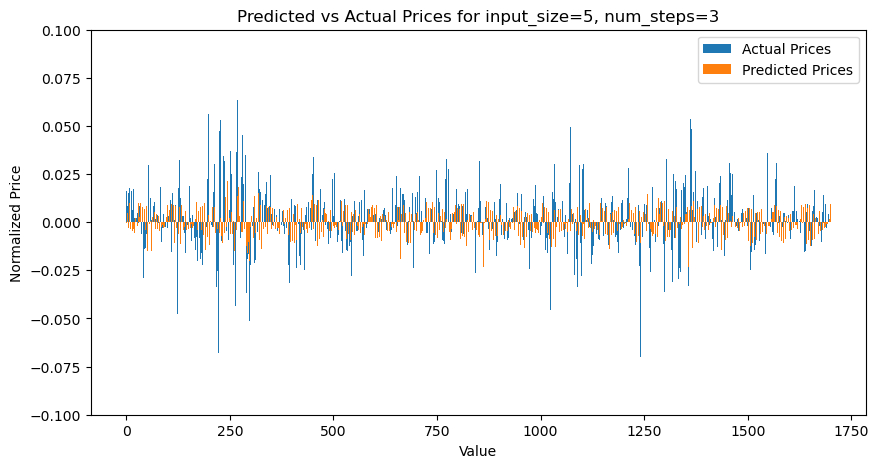

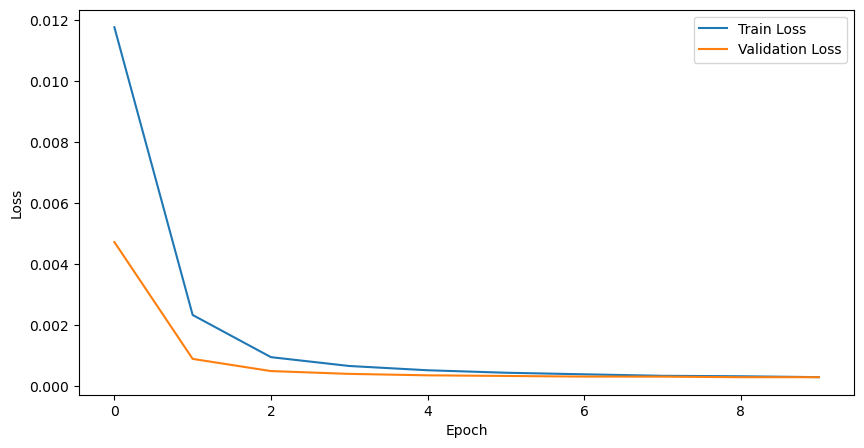

100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 15.51it/s]


Epoch 1/10, Train Loss: 0.0059, Val Loss: 0.0013


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.99it/s]


Epoch 2/10, Train Loss: 0.0014, Val Loss: 0.0005


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.14it/s]


Epoch 3/10, Train Loss: 0.0009, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.98it/s]


Epoch 4/10, Train Loss: 0.0006, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.94it/s]


Epoch 5/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 15.66it/s]


Epoch 6/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.07it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.80it/s]


Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 16.84it/s]


Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 15.97it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


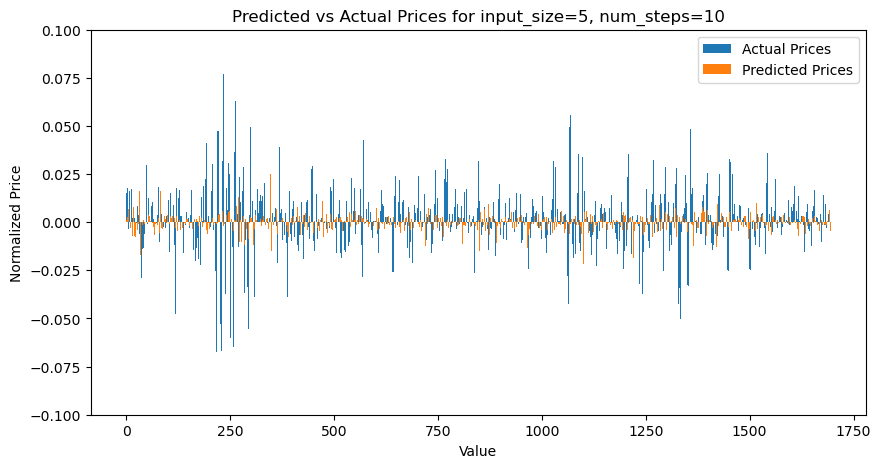

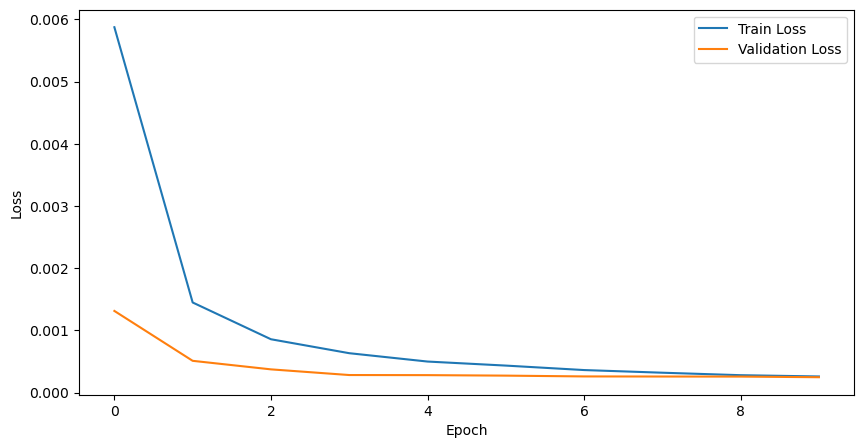

100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 10.89it/s]


Epoch 1/10, Train Loss: 0.0033, Val Loss: 0.0010


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.41it/s]


Epoch 2/10, Train Loss: 0.0009, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.66it/s]


Epoch 3/10, Train Loss: 0.0006, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 10.87it/s]


Epoch 4/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.22it/s]


Epoch 5/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.41it/s]


Epoch 6/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.56it/s]


Epoch 7/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.58it/s]


Epoch 8/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.45it/s]


Epoch 9/10, Train Loss: 0.0002, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:03<00:00, 11.61it/s]


Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


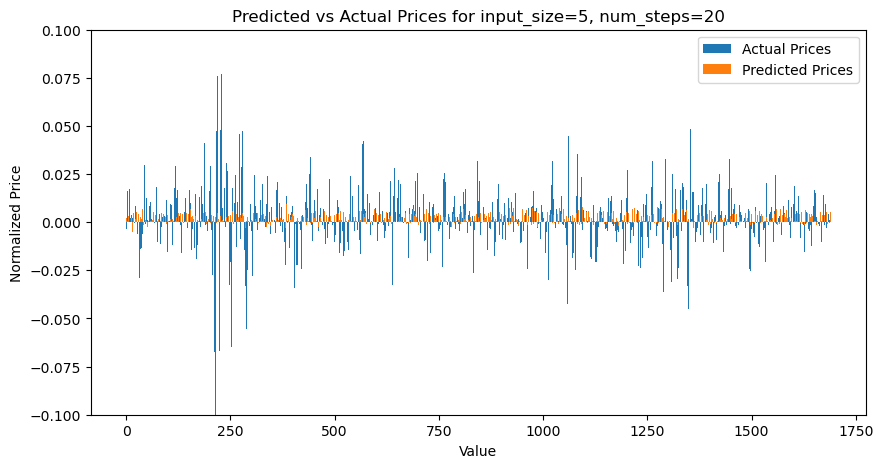

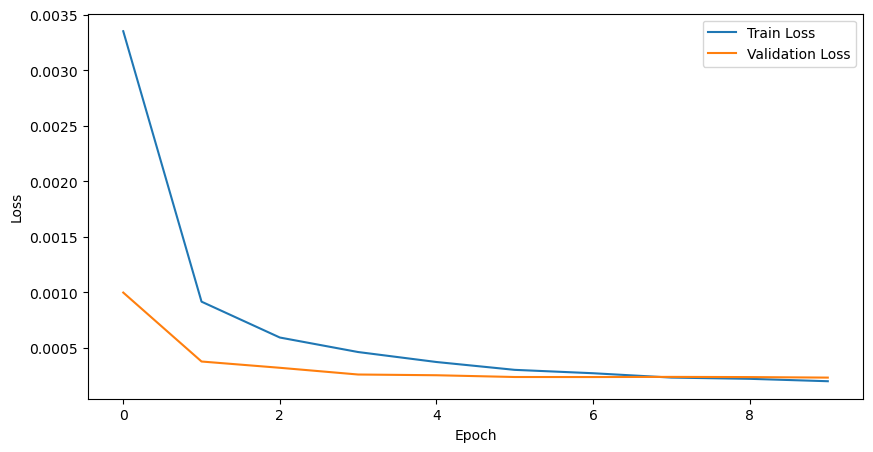

100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.64it/s]


Epoch 1/10, Train Loss: 0.0156, Val Loss: 0.0039


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.81it/s]


Epoch 2/10, Train Loss: 0.0023, Val Loss: 0.0005


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.62it/s]


Epoch 3/10, Train Loss: 0.0011, Val Loss: 0.0004


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.86it/s]


Epoch 4/10, Train Loss: 0.0008, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch 5/10, Train Loss: 0.0006, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.67it/s]


Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.87it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.89it/s]


Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.94it/s]


Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 43/43 [00:04<00:00,  8.96it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


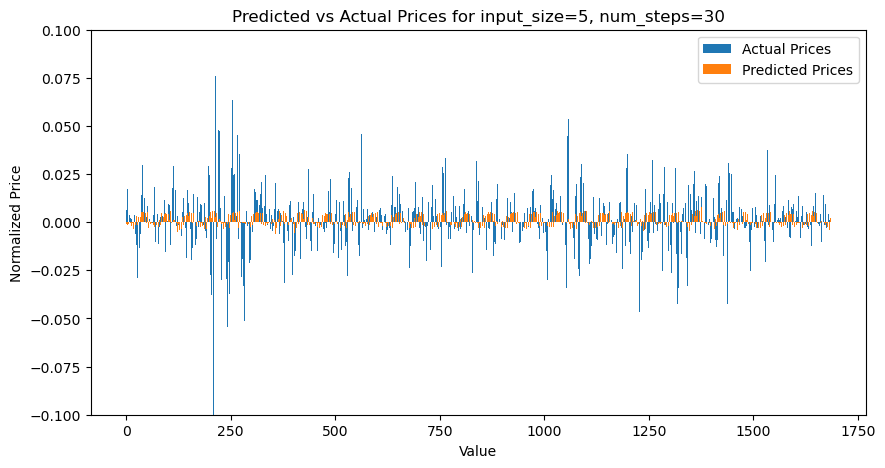

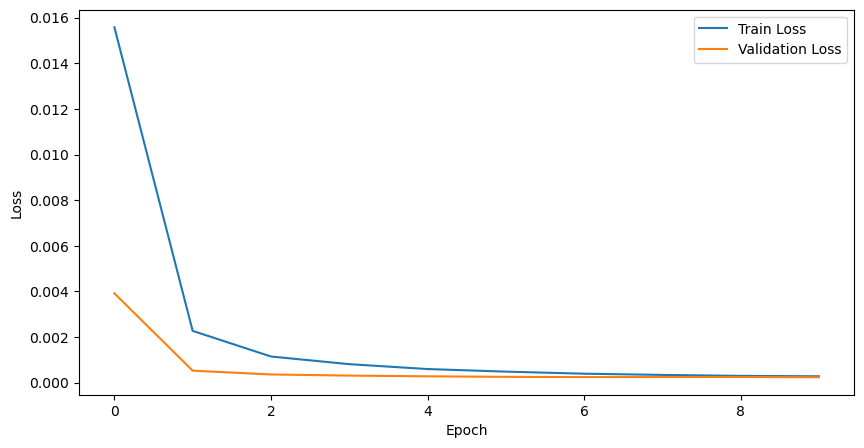

100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch 1/10, Train Loss: 0.0080, Val Loss: 0.0035


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch 2/10, Train Loss: 0.0036, Val Loss: 0.0014


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch 3/10, Train Loss: 0.0020, Val Loss: 0.0006


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch 4/10, Train Loss: 0.0015, Val Loss: 0.0004


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  7.00it/s]


Epoch 5/10, Train Loss: 0.0011, Val Loss: 0.0005


100%|███████████████████████████████████████████| 42/42 [00:05<00:00,  7.00it/s]


Epoch 6/10, Train Loss: 0.0009, Val Loss: 0.0004


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.90it/s]


Epoch 7/10, Train Loss: 0.0007, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.91it/s]


Epoch 8/10, Train Loss: 0.0005, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:06<00:00,  6.90it/s]


Epoch 9/10, Train Loss: 0.0004, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:05<00:00,  7.00it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0003
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


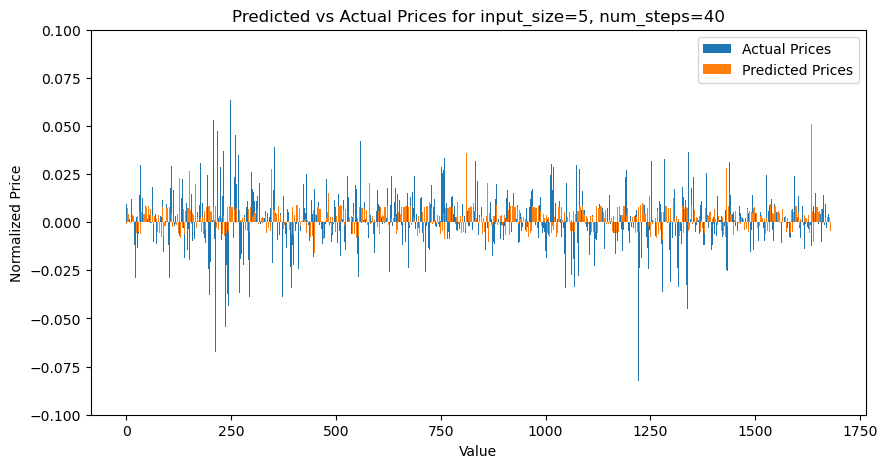

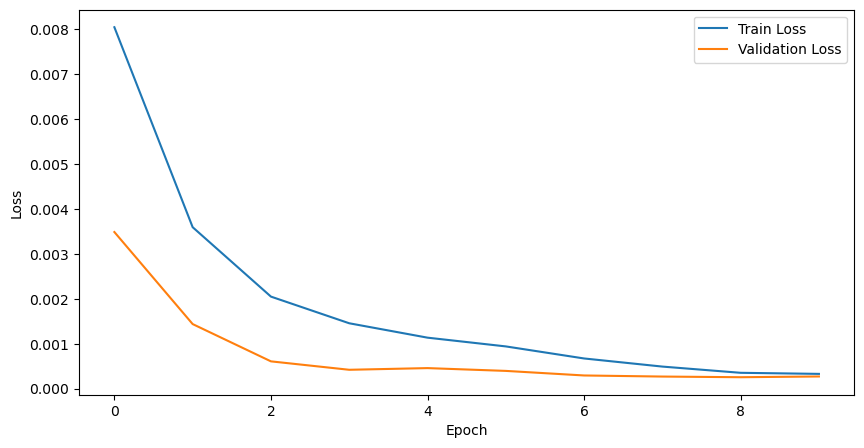

100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.80it/s]


Epoch 1/10, Train Loss: 0.0108, Val Loss: 0.0030


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.90it/s]


Epoch 2/10, Train Loss: 0.0041, Val Loss: 0.0022


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.60it/s]


Epoch 3/10, Train Loss: 0.0033, Val Loss: 0.0015


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.74it/s]


Epoch 4/10, Train Loss: 0.0022, Val Loss: 0.0006


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.82it/s]


Epoch 5/10, Train Loss: 0.0013, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.81it/s]


Epoch 6/10, Train Loss: 0.0010, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.81it/s]


Epoch 7/10, Train Loss: 0.0008, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.89it/s]


Epoch 8/10, Train Loss: 0.0007, Val Loss: 0.0003


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.81it/s]


Epoch 9/10, Train Loss: 0.0006, Val Loss: 0.0002


100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.91it/s]


Epoch 10/10, Train Loss: 0.0005, Val Loss: 0.0002
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=5, bias=True)
)


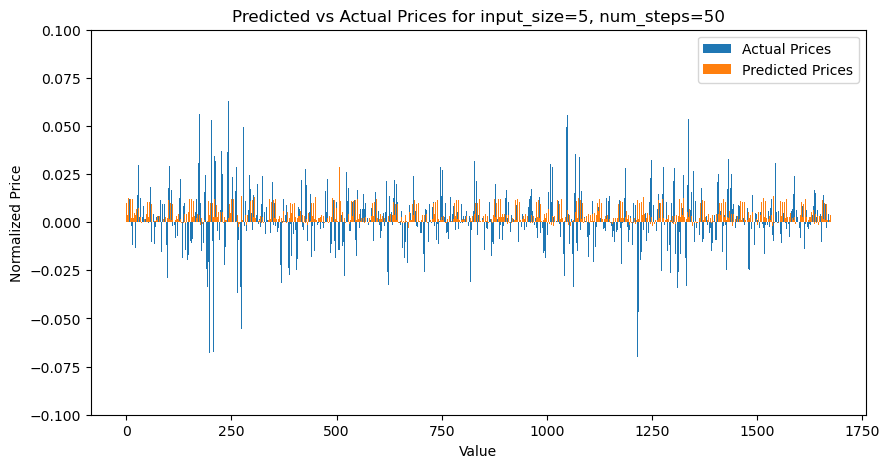

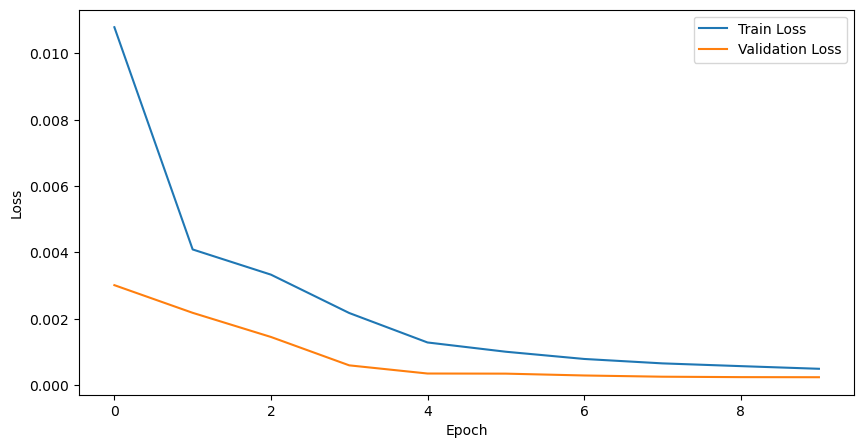

100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.69it/s]


Epoch 1/10, Train Loss: 0.0089, Val Loss: 0.0053


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.72it/s]


Epoch 2/10, Train Loss: 0.0039, Val Loss: 0.0024


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 14.17it/s]


Epoch 3/10, Train Loss: 0.0022, Val Loss: 0.0013


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.47it/s]


Epoch 4/10, Train Loss: 0.0016, Val Loss: 0.0010


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.58it/s]


Epoch 5/10, Train Loss: 0.0012, Val Loss: 0.0009


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 14.06it/s]


Epoch 6/10, Train Loss: 0.0010, Val Loss: 0.0007


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.13it/s]


Epoch 7/10, Train Loss: 0.0009, Val Loss: 0.0007


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.92it/s]


Epoch 8/10, Train Loss: 0.0008, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.43it/s]


Epoch 9/10, Train Loss: 0.0007, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.26it/s]


Epoch 10/10, Train Loss: 0.0006, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


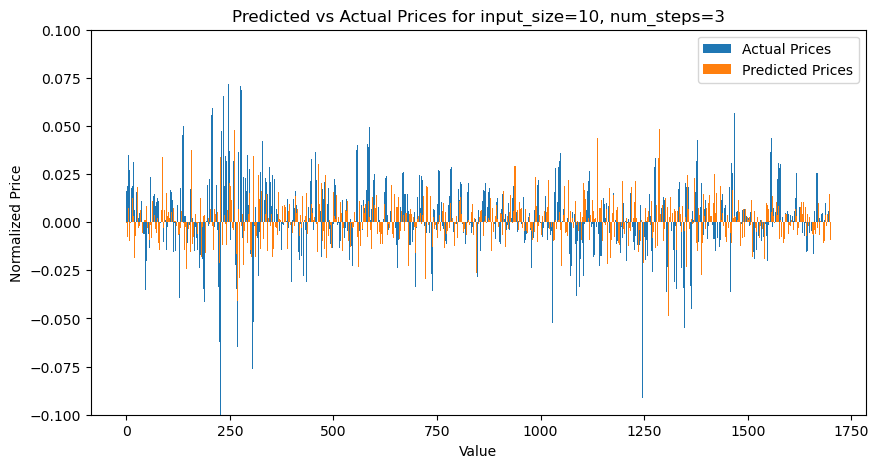

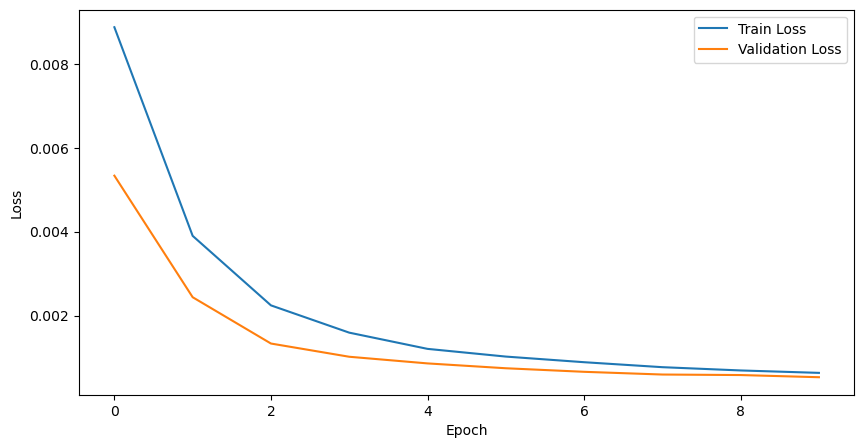

100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.30it/s]


Epoch 1/10, Train Loss: 0.0083, Val Loss: 0.0037


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.12it/s]


Epoch 2/10, Train Loss: 0.0029, Val Loss: 0.0017


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.14it/s]


Epoch 3/10, Train Loss: 0.0019, Val Loss: 0.0013


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.06it/s]


Epoch 4/10, Train Loss: 0.0015, Val Loss: 0.0011


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.05it/s]


Epoch 5/10, Train Loss: 0.0013, Val Loss: 0.0009


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.11it/s]


Epoch 6/10, Train Loss: 0.0011, Val Loss: 0.0008


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.30it/s]


Epoch 7/10, Train Loss: 0.0009, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.16it/s]


Epoch 8/10, Train Loss: 0.0009, Val Loss: 0.0006


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.05it/s]


Epoch 9/10, Train Loss: 0.0008, Val Loss: 0.0005


100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.35it/s]


Epoch 10/10, Train Loss: 0.0007, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


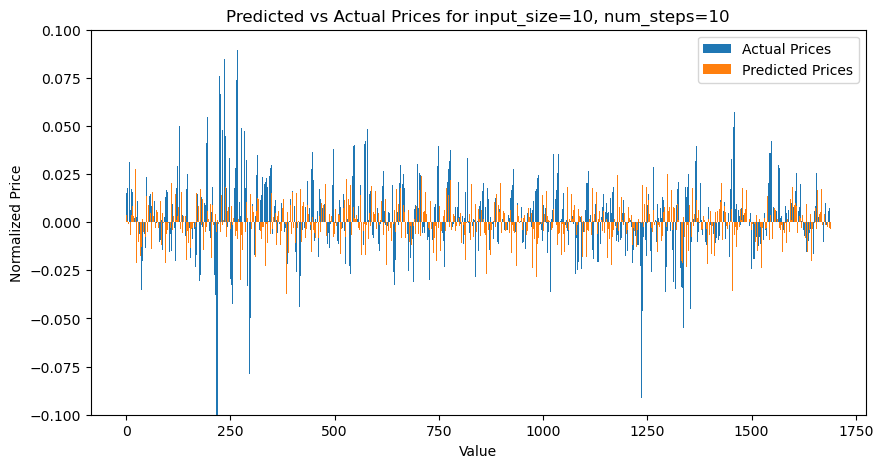

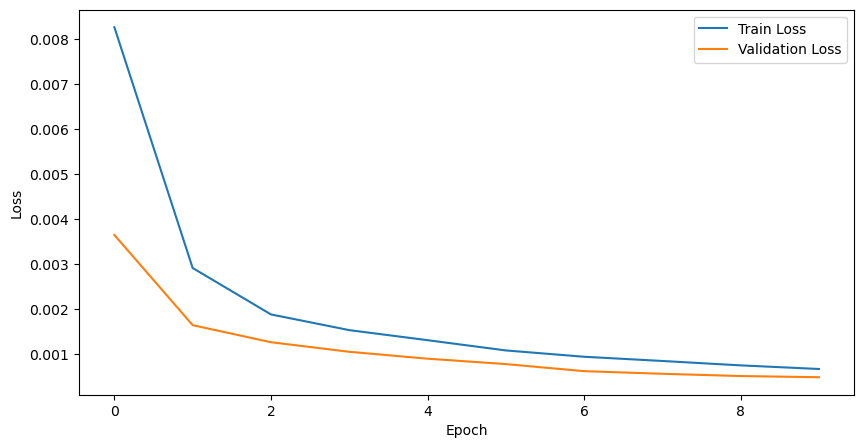

100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.84it/s]


Epoch 1/10, Train Loss: 0.0112, Val Loss: 0.0064


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.57it/s]


Epoch 2/10, Train Loss: 0.0046, Val Loss: 0.0017


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.82it/s]


Epoch 3/10, Train Loss: 0.0020, Val Loss: 0.0009


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.74it/s]


Epoch 4/10, Train Loss: 0.0014, Val Loss: 0.0006


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.04it/s]


Epoch 5/10, Train Loss: 0.0011, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.95it/s]


Epoch 6/10, Train Loss: 0.0009, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.04it/s]


Epoch 7/10, Train Loss: 0.0008, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.13it/s]


Epoch 8/10, Train Loss: 0.0007, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.16it/s]


Epoch 9/10, Train Loss: 0.0006, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.23it/s]


Epoch 10/10, Train Loss: 0.0006, Val Loss: 0.0004
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


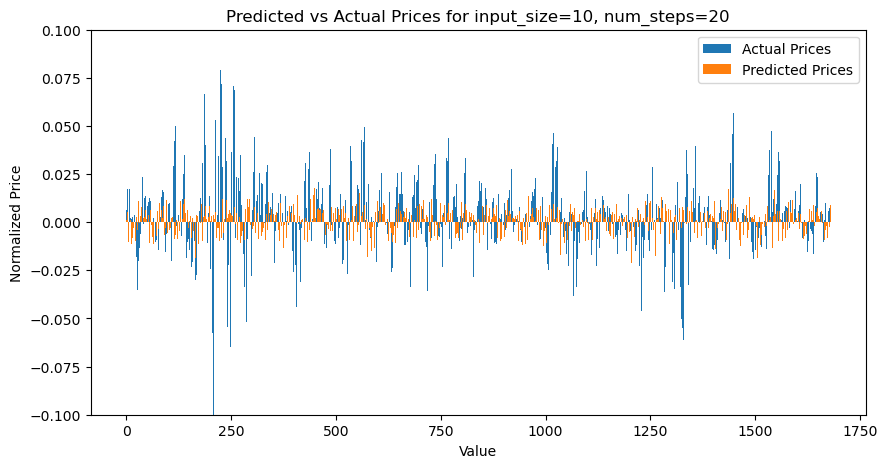

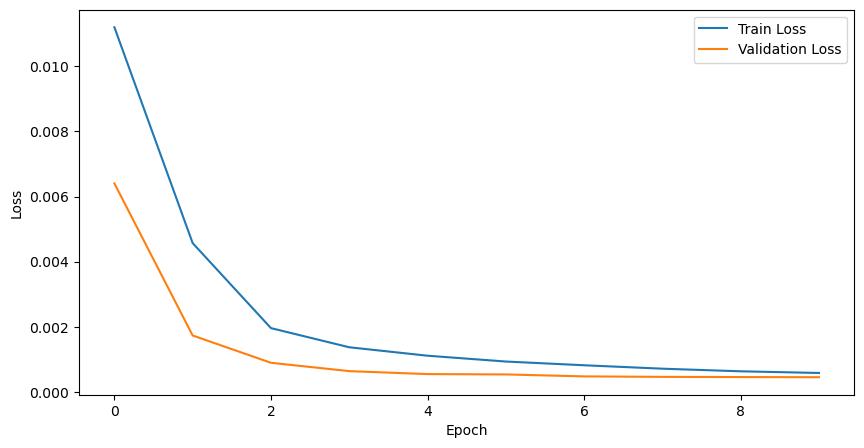

100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.57it/s]


Epoch 1/10, Train Loss: 0.0137, Val Loss: 0.0064


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.24it/s]


Epoch 2/10, Train Loss: 0.0067, Val Loss: 0.0032


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.55it/s]


Epoch 3/10, Train Loss: 0.0035, Val Loss: 0.0019


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.51it/s]


Epoch 4/10, Train Loss: 0.0027, Val Loss: 0.0012


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.63it/s]


Epoch 5/10, Train Loss: 0.0019, Val Loss: 0.0009


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.80it/s]


Epoch 6/10, Train Loss: 0.0015, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.72it/s]


Epoch 7/10, Train Loss: 0.0013, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.72it/s]


Epoch 8/10, Train Loss: 0.0011, Val Loss: 0.0004


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.73it/s]


Epoch 9/10, Train Loss: 0.0010, Val Loss: 0.0004


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  6.66it/s]


Epoch 10/10, Train Loss: 0.0010, Val Loss: 0.0004
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


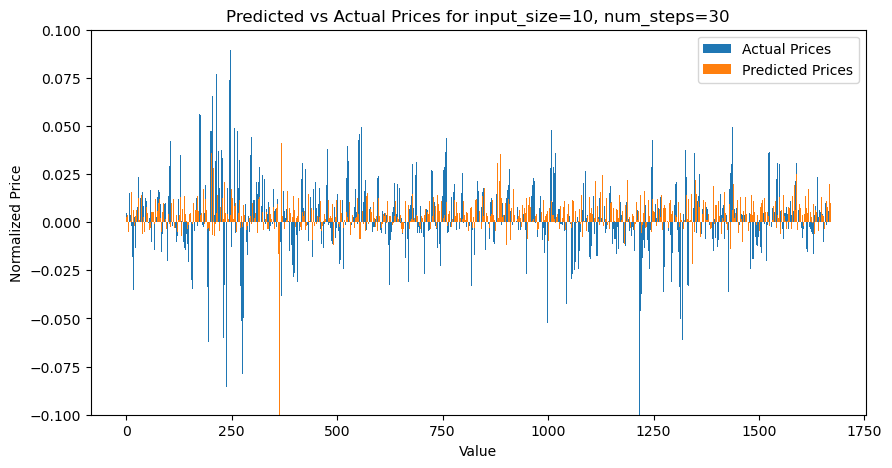

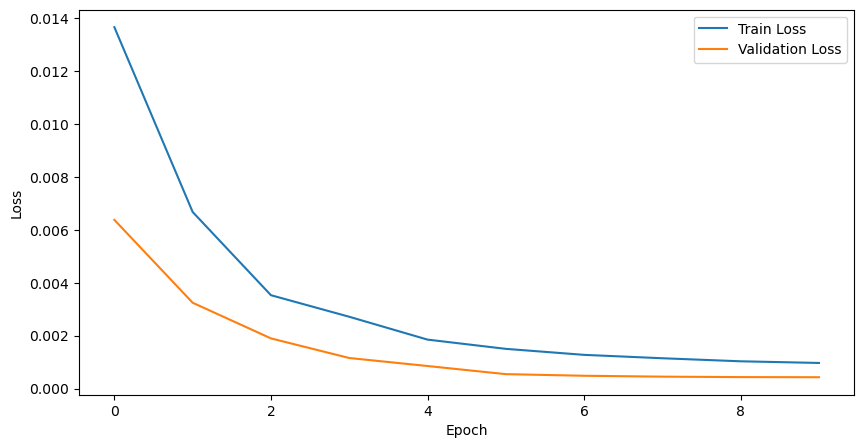

100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.58it/s]


Epoch 1/10, Train Loss: 0.0245, Val Loss: 0.0160


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.45it/s]


Epoch 2/10, Train Loss: 0.0141, Val Loss: 0.0086


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.54it/s]


Epoch 3/10, Train Loss: 0.0067, Val Loss: 0.0028


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.60it/s]


Epoch 4/10, Train Loss: 0.0042, Val Loss: 0.0019


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.41it/s]


Epoch 5/10, Train Loss: 0.0028, Val Loss: 0.0008


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.64it/s]


Epoch 6/10, Train Loss: 0.0022, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.64it/s]


Epoch 7/10, Train Loss: 0.0018, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.45it/s]


Epoch 8/10, Train Loss: 0.0016, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.50it/s]


Epoch 9/10, Train Loss: 0.0014, Val Loss: 0.0005


100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.67it/s]


Epoch 10/10, Train Loss: 0.0013, Val Loss: 0.0005
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


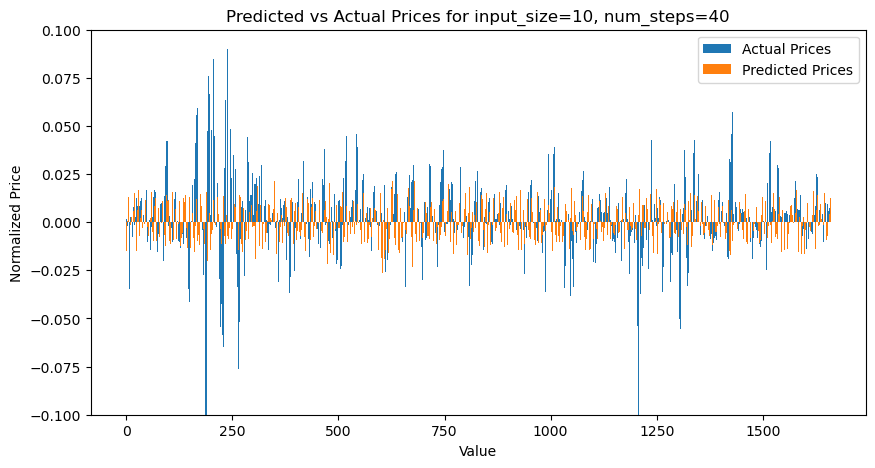

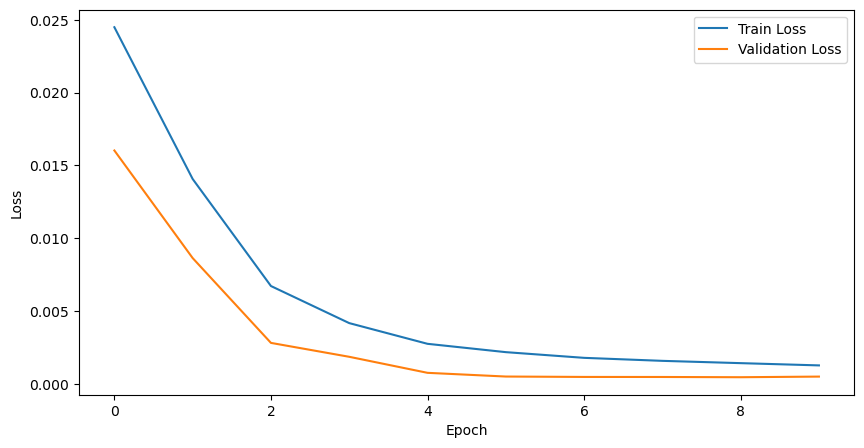

100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.62it/s]


Epoch 1/10, Train Loss: 0.0123, Val Loss: 0.0075


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.78it/s]


Epoch 2/10, Train Loss: 0.0074, Val Loss: 0.0047


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.78it/s]


Epoch 3/10, Train Loss: 0.0048, Val Loss: 0.0029


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.73it/s]


Epoch 4/10, Train Loss: 0.0037, Val Loss: 0.0023


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.80it/s]


Epoch 5/10, Train Loss: 0.0029, Val Loss: 0.0018


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.62it/s]


Epoch 6/10, Train Loss: 0.0023, Val Loss: 0.0012


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.82it/s]


Epoch 7/10, Train Loss: 0.0017, Val Loss: 0.0008


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.70it/s]


Epoch 8/10, Train Loss: 0.0014, Val Loss: 0.0008


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.79it/s]


Epoch 9/10, Train Loss: 0.0012, Val Loss: 0.0006


100%|███████████████████████████████████████████| 21/21 [00:04<00:00,  4.90it/s]


Epoch 10/10, Train Loss: 0.0011, Val Loss: 0.0006
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


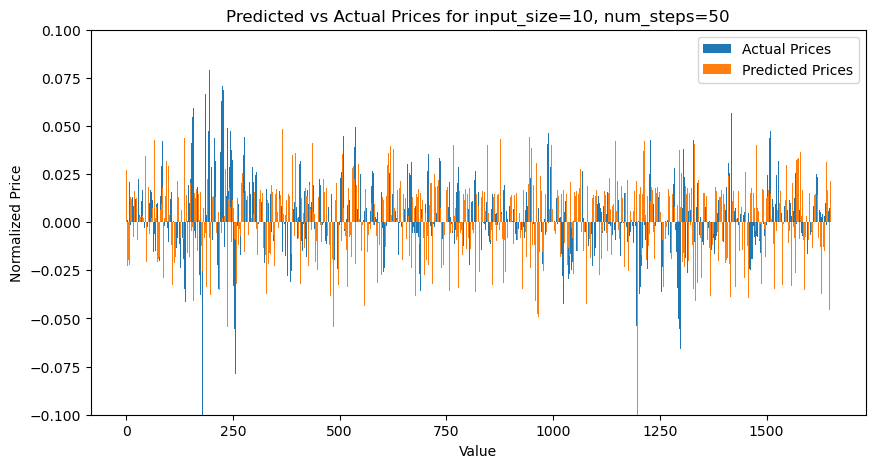

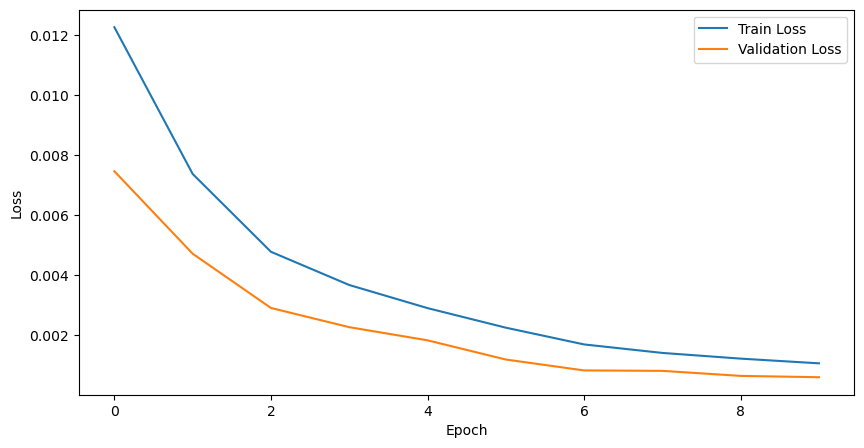

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.97it/s]


Epoch 1/10, Train Loss: 0.0132, Val Loss: 0.0110


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.59it/s]


Epoch 2/10, Train Loss: 0.0110, Val Loss: 0.0098


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.03it/s]


Epoch 3/10, Train Loss: 0.0096, Val Loss: 0.0089


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.29it/s]


Epoch 4/10, Train Loss: 0.0089, Val Loss: 0.0082


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.39it/s]


Epoch 5/10, Train Loss: 0.0081, Val Loss: 0.0076


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.28it/s]


Epoch 6/10, Train Loss: 0.0076, Val Loss: 0.0070


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.76it/s]


Epoch 7/10, Train Loss: 0.0070, Val Loss: 0.0063


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.85it/s]


Epoch 8/10, Train Loss: 0.0064, Val Loss: 0.0057


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.04it/s]


Epoch 9/10, Train Loss: 0.0058, Val Loss: 0.0051


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.06it/s]


Epoch 10/10, Train Loss: 0.0054, Val Loss: 0.0046
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


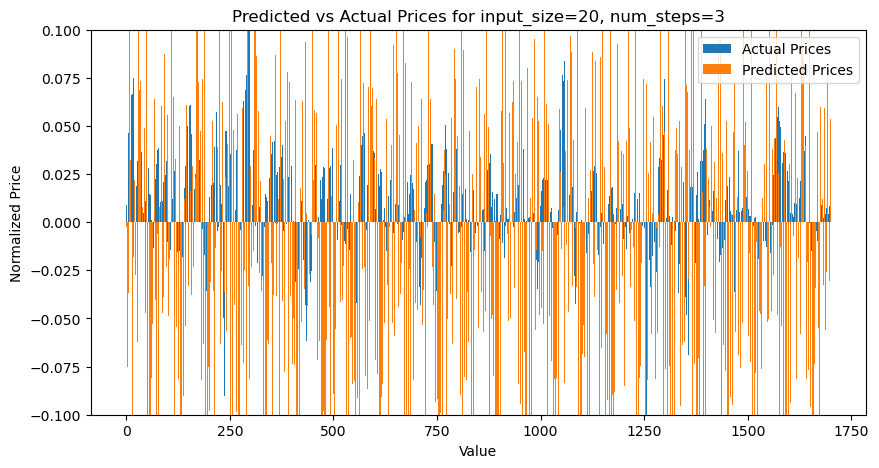

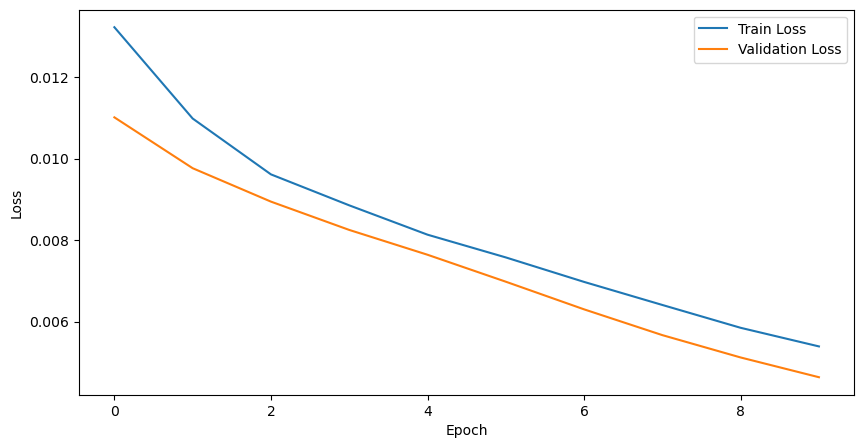

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.70it/s]


Epoch 1/10, Train Loss: 0.0160, Val Loss: 0.0123


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.69it/s]


Epoch 2/10, Train Loss: 0.0117, Val Loss: 0.0090


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.63it/s]


Epoch 3/10, Train Loss: 0.0088, Val Loss: 0.0070


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.98it/s]


Epoch 4/10, Train Loss: 0.0069, Val Loss: 0.0058


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.13it/s]


Epoch 5/10, Train Loss: 0.0055, Val Loss: 0.0047


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.94it/s]


Epoch 6/10, Train Loss: 0.0047, Val Loss: 0.0039


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.21it/s]


Epoch 7/10, Train Loss: 0.0041, Val Loss: 0.0035


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.34it/s]


Epoch 8/10, Train Loss: 0.0037, Val Loss: 0.0030


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.19it/s]


Epoch 9/10, Train Loss: 0.0033, Val Loss: 0.0025


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.24it/s]


Epoch 10/10, Train Loss: 0.0030, Val Loss: 0.0022
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


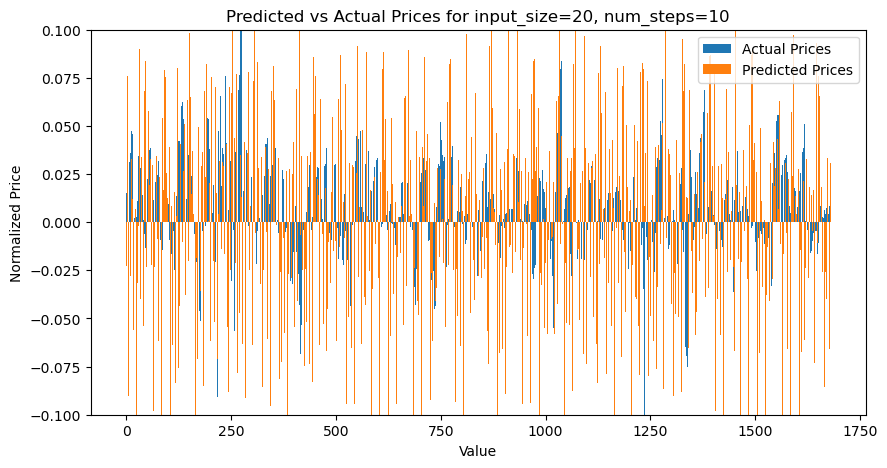

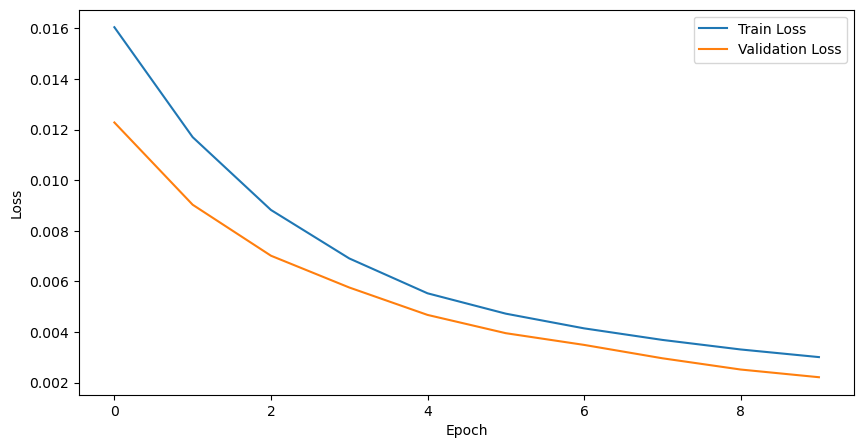

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.32it/s]


Epoch 1/10, Train Loss: 0.0134, Val Loss: 0.0081


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.37it/s]


Epoch 2/10, Train Loss: 0.0081, Val Loss: 0.0056


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.27it/s]


Epoch 3/10, Train Loss: 0.0060, Val Loss: 0.0045


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.39it/s]


Epoch 4/10, Train Loss: 0.0044, Val Loss: 0.0034


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.44it/s]


Epoch 5/10, Train Loss: 0.0036, Val Loss: 0.0028


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.54it/s]


Epoch 6/10, Train Loss: 0.0031, Val Loss: 0.0025


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.02it/s]


Epoch 7/10, Train Loss: 0.0029, Val Loss: 0.0023


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.43it/s]


Epoch 8/10, Train Loss: 0.0027, Val Loss: 0.0021


100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.58it/s]


Epoch 9/10, Train Loss: 0.0025, Val Loss: 0.0020


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  5.48it/s]


Epoch 10/10, Train Loss: 0.0024, Val Loss: 0.0019
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


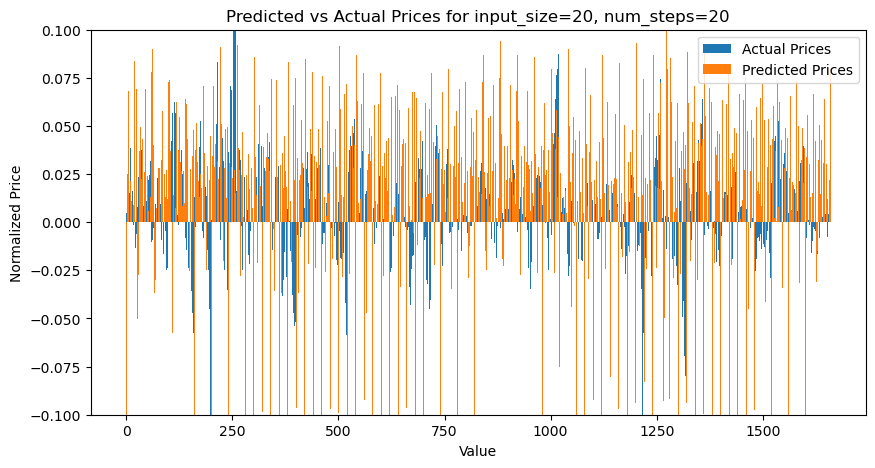

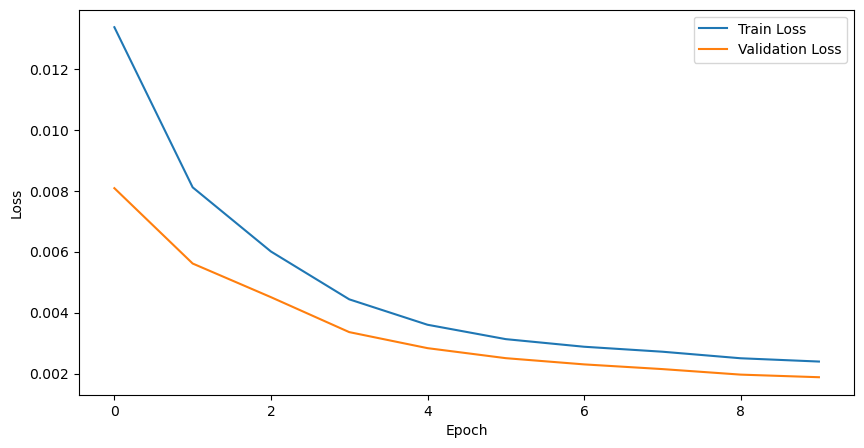

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.66it/s]


Epoch 1/10, Train Loss: 0.0263, Val Loss: 0.0179


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.38it/s]


Epoch 2/10, Train Loss: 0.0165, Val Loss: 0.0115


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.68it/s]


Epoch 3/10, Train Loss: 0.0118, Val Loss: 0.0081


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.84it/s]


Epoch 4/10, Train Loss: 0.0088, Val Loss: 0.0067


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch 5/10, Train Loss: 0.0073, Val Loss: 0.0052


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch 6/10, Train Loss: 0.0060, Val Loss: 0.0045


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.86it/s]


Epoch 7/10, Train Loss: 0.0052, Val Loss: 0.0039


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.82it/s]


Epoch 8/10, Train Loss: 0.0046, Val Loss: 0.0034


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.87it/s]


Epoch 9/10, Train Loss: 0.0044, Val Loss: 0.0038


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.88it/s]


Epoch 10/10, Train Loss: 0.0041, Val Loss: 0.0031
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


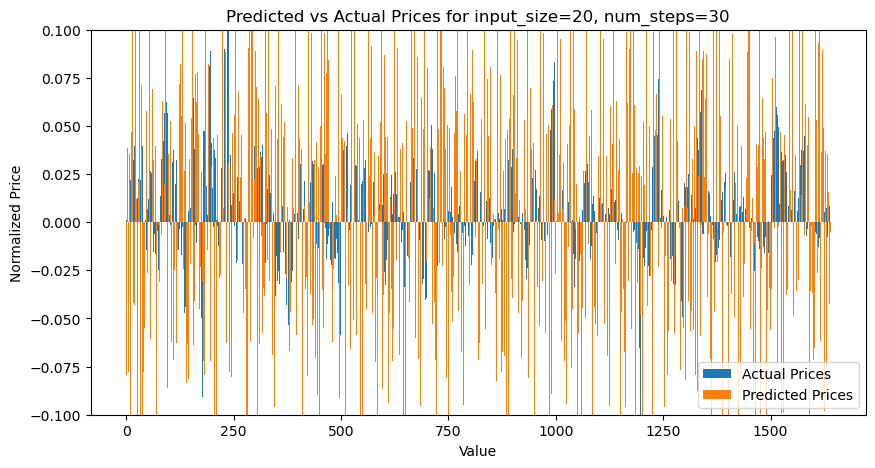

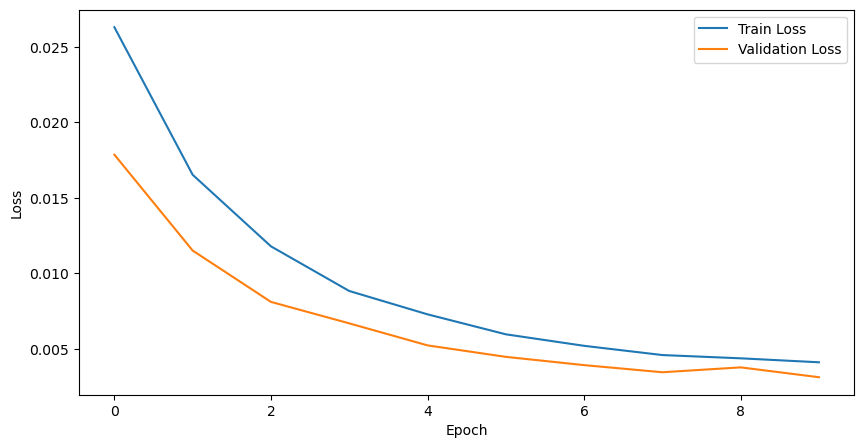

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.29it/s]


Epoch 1/10, Train Loss: 0.0165, Val Loss: 0.0121


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.28it/s]


Epoch 2/10, Train Loss: 0.0126, Val Loss: 0.0091


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.33it/s]


Epoch 3/10, Train Loss: 0.0097, Val Loss: 0.0078


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.31it/s]


Epoch 4/10, Train Loss: 0.0079, Val Loss: 0.0059


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.27it/s]


Epoch 5/10, Train Loss: 0.0066, Val Loss: 0.0055


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.32it/s]


Epoch 6/10, Train Loss: 0.0056, Val Loss: 0.0044


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.33it/s]


Epoch 7/10, Train Loss: 0.0049, Val Loss: 0.0037


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.25it/s]


Epoch 8/10, Train Loss: 0.0045, Val Loss: 0.0034


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.24it/s]


Epoch 9/10, Train Loss: 0.0043, Val Loss: 0.0033


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.32it/s]


Epoch 10/10, Train Loss: 0.0041, Val Loss: 0.0032
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


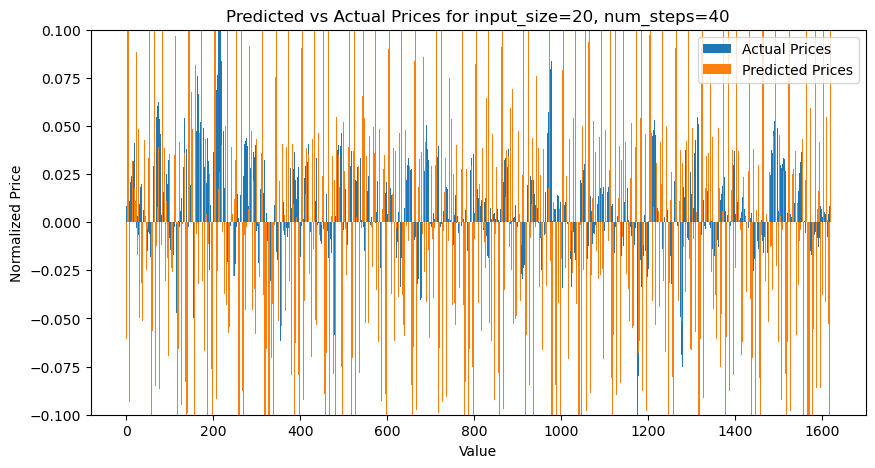

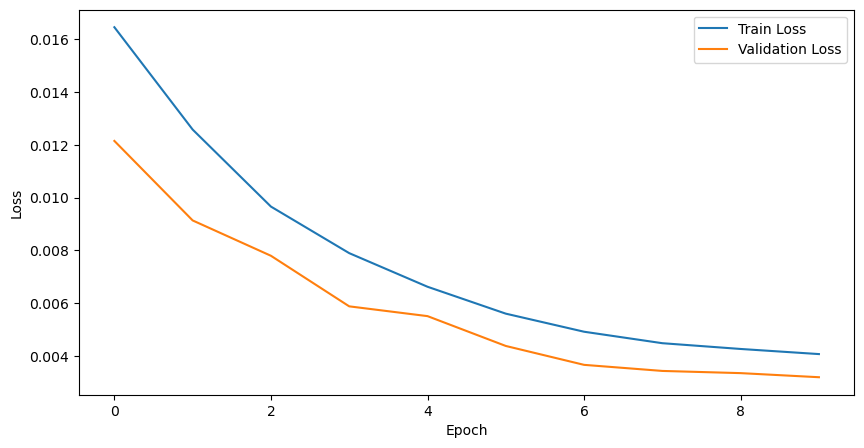

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 1/10, Train Loss: 0.0144, Val Loss: 0.0111


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch 2/10, Train Loss: 0.0106, Val Loss: 0.0088


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


Epoch 3/10, Train Loss: 0.0087, Val Loss: 0.0070


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 4/10, Train Loss: 0.0076, Val Loss: 0.0065


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 5/10, Train Loss: 0.0063, Val Loss: 0.0052


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch 6/10, Train Loss: 0.0055, Val Loss: 0.0046


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch 7/10, Train Loss: 0.0050, Val Loss: 0.0046


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch 8/10, Train Loss: 0.0048, Val Loss: 0.0041


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch 9/10, Train Loss: 0.0044, Val Loss: 0.0038


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 10/10, Train Loss: 0.0041, Val Loss: 0.0037
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=20, bias=True)
)


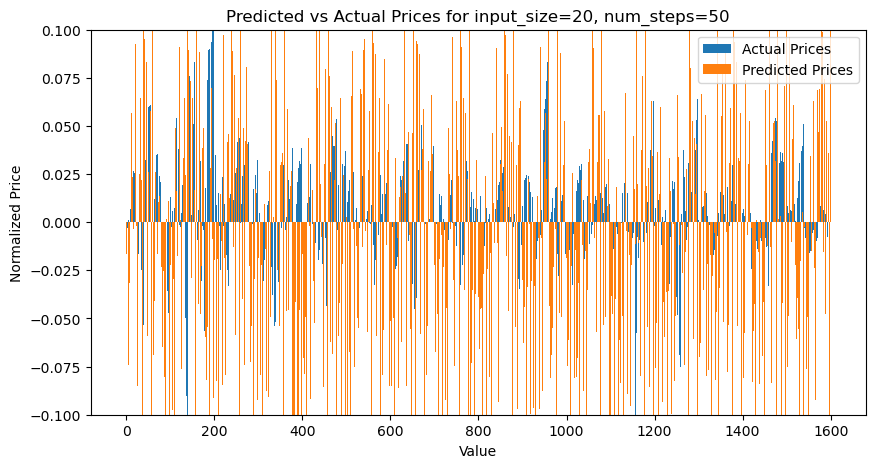

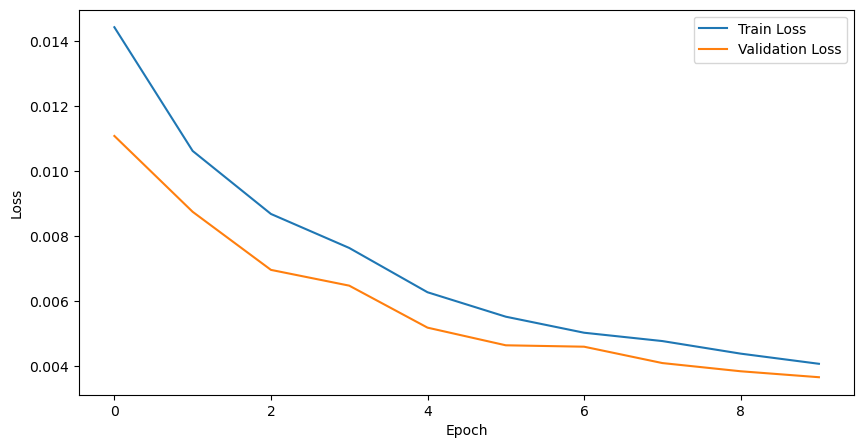

In [30]:
# GRU (setting SEARCH_NEEDED = TRUE will RUN LONG TIME!!!)
cell_type = 'gru'
SEARCH_NEEDED_GRU = True
df_best_model = get_best_model(cell_type, input_size_values, num_steps_values, SEARCH_NEEDED=SEARCH_NEEDED_GRU)

In [31]:
df_best_model

Unnamed: 0                 20.000000
Input Size                 10.000000
Number of Steps            20.000000
Test Loss                   0.000641
Classification Accuracy     0.520833
Duration                   40.412686
Name: 20, dtype: float64

100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.49it/s]


Epoch 1/10, Train Loss: 0.0138, Val Loss: 0.0074


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.70it/s]


Epoch 2/10, Train Loss: 0.0061, Val Loss: 0.0038


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.81it/s]


Epoch 3/10, Train Loss: 0.0035, Val Loss: 0.0022


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.93it/s]


Epoch 4/10, Train Loss: 0.0026, Val Loss: 0.0016


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.08it/s]


Epoch 5/10, Train Loss: 0.0021, Val Loss: 0.0013


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.89it/s]


Epoch 6/10, Train Loss: 0.0017, Val Loss: 0.0010


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.91it/s]


Epoch 7/10, Train Loss: 0.0014, Val Loss: 0.0008


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.01it/s]


Epoch 8/10, Train Loss: 0.0012, Val Loss: 0.0007


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  8.05it/s]


Epoch 9/10, Train Loss: 0.0010, Val Loss: 0.0006


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.81it/s]


Epoch 10/10, Train Loss: 0.0009, Val Loss: 0.0006
CustomRNNModel(
  (layers): ModuleList(
    (0-1): 2 x CustomGRUCell(
      (ln_z): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_r): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_h): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
)


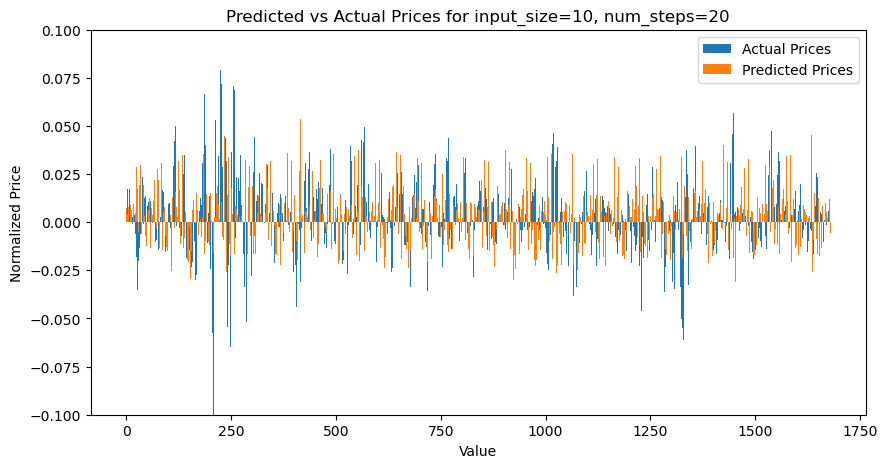

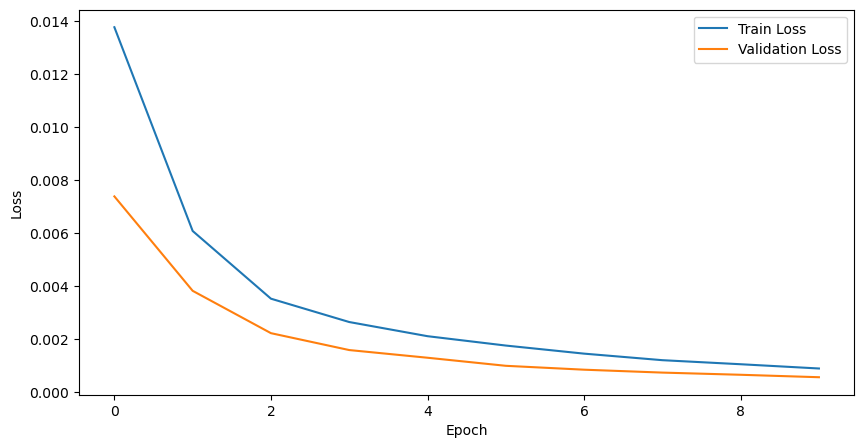

Test loss of best model: 0.0009667156264185905
Classification accuracy of best model: 0.5017857142857143
Duration of best model: 41.60518002510071


In [32]:
# Modify the input_size and num_steps attributes
data_preparation = DataPreparation(dataset_name, num_steps=int(df_best_model['Number of Steps']), input_size=int(df_best_model['Input Size']))

# Train & Evaluate model
evaluation_results = TrainAndPredict(data_preparation, cell_type, train_needed=True)
print("Test loss of best model:", evaluation_results.test_loss)
print("Classification accuracy of best model:", evaluation_results.classification_accuracy)
print("Duration of best model:", evaluation_results.duration)